# 📊 Análisis Exploratorio de Datos (EDA) - Geotab

Este notebook presenta un análisis exploratorio completo de los datos extraídos de la plataforma Geotab, incluyendo información sobre dispositivos, viajes, usuarios, zonas, reglas y datos de fallas.

## 🎯 Objetivos del Análisis

1. **Exploración inicial** de la estructura y calidad de los datos
2. **Identificación de patrones** en el comportamiento de la flota
3. **Análisis de rendimiento** de vehículos y conductores
4. **Detección de anomalías** y problemas operativos
5. **Generación de insights** para la toma de decisiones

---

# 📚 Imports y Librerías

In [6]:
# Librerías de manipulación de datos
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import glob

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Configuración de Plotly
import plotly.io as pio
pio.templates.default = "plotly_white"

print("✅ Todas las librerías importadas correctamente")

✅ Todas las librerías importadas correctamente


# 🛠️ Funciones Auxiliares

In [8]:
def load_latest_csv_files(export_dir="./exports"):
    """
    Cargar los archivos CSV más recientes de cada tipo de entidad.
    
    Returns:
        dict: Diccionario con DataFrames de cada entidad
    """
    # Buscar archivos CSV más recientes
    csv_files = glob.glob(os.path.join(export_dir, "*.csv"))
    
    # Agrupar por tipo de entidad
    entity_types = {}
    for file_path in csv_files:
        filename = os.path.basename(file_path)
        entity_type = filename.split('_')[0]
        
        if entity_type not in entity_types:
            entity_types[entity_type] = []
        entity_types[entity_type].append(file_path)
    
    # Cargar el archivo más reciente de cada tipo
    dataframes = {}
    for entity_type, files in entity_types.items():
        if files:
            # Ordenar por fecha (más reciente primero)
            latest_file = sorted(files)[-1]
            print(f"📁 Cargando {entity_type}: {os.path.basename(latest_file)}")
            
            try:
                df = pd.read_csv(latest_file)
                dataframes[entity_type] = df
                print(f"   ✅ {len(df):,} registros cargados")
            except Exception as e:
                print(f"   ❌ Error cargando {entity_type}: {e}")
    
    return dataframes


def show_dataframe_info(df, name):
    """
    Mostrar información básica de un DataFrame.
    
    Args:
        df: DataFrame a analizar
        name: Nombre del DataFrame
    """
    print(f"\n{'='*50}")
    print(f"📊 INFORMACIÓN BÁSICA - {name.upper()}")
    print(f"{'='*50}")
    print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print(f"\n🔧 TIPOS DE DATOS:")
    print(df.dtypes.value_counts())
    
    print(f"\n❓ VALORES NULOS:")
    null_counts = df.isnull().sum()
    null_percentages = (null_counts / len(df)) * 100
    null_info = pd.DataFrame({
        'Nulos': null_counts,
        'Porcentaje': null_percentages.round(2)
    })
    print(null_info[null_info['Nulos'] > 0])


def detect_duplicates(df, name):
    """
    Detectar y analizar duplicados en un DataFrame.
    
    Args:
        df: DataFrame a analizar
        name: Nombre del DataFrame
    """
    print(f"\n🔍 ANÁLISIS DE DUPLICADOS - {name.upper()}")
    print(f"{'='*50}")
    
    # Duplicados completos
    full_duplicates = df.duplicated().sum()
    print(f"Filas completamente duplicadas: {full_duplicates:,} ({full_duplicates/len(df)*100:.2f}%)")
    
    # Analizar columnas potencialmente únicas
    potential_id_columns = [col for col in df.columns if 'id' in col.lower() or 'key' in col.lower()]
    
    for col in potential_id_columns:
        if col in df.columns:
            unique_count = df[col].nunique()
            duplicate_count = len(df) - unique_count
            print(f"Columna '{col}': {unique_count:,} únicos, {duplicate_count:,} duplicados")


def analyze_geotab_timestamps(df, timestamp_columns):
    """
    Analizar columnas de timestamp típicas de Geotab.
    
    Args:
        df: DataFrame con datos de Geotab
        timestamp_columns: Lista de columnas que contienen timestamps
    """
    print("\n🕐 ANÁLISIS DE TIMESTAMPS")
    print("="*40)
    
    for col in timestamp_columns:
        if col in df.columns:
            try:
                # Intentar convertir a datetime
                df[col] = pd.to_datetime(df[col], errors='coerce')
                
                if df[col].notna().sum() > 0:
                    print(f"\nColumna: {col}")
                    print(f"  Rango: {df[col].min()} a {df[col].max()}")
                    print(f"  Valores válidos: {df[col].notna().sum():,}/{len(df):,}")
                    
                    # Distribución por fecha
                    if df[col].notna().sum() > 100:
                        date_counts = df[col].dt.date.value_counts().head()
                        print(f"  Fechas más frecuentes:\n{date_counts}")
            except Exception as e:
                print(f"Error procesando {col}: {e}")

print("✅ Funciones auxiliares definidas correctamente")

✅ Funciones auxiliares definidas correctamente


# 📂 Carga de Datos

In [9]:
# Cargar todos los datasets disponibles
print("🚀 Iniciando carga de datos de Geotab...")
print("="*50)

# Cargar archivos CSV
datasets = load_latest_csv_files("./exports")

print(f"\n📊 RESUMEN DE CARGA:")
print(f"{'='*30}")
for name, df in datasets.items():
    print(f"{name:12}: {len(df):8,} registros × {df.shape[1]:2} columnas")

print(f"\nTotal de datasets cargados: {len(datasets)}")

# Asignar datasets a variables individuales para facilitar el análisis
if 'Device' in datasets:
    devices_df = datasets['Device']
if 'Trip' in datasets:
    trips_df = datasets['Trip']
if 'User' in datasets:
    users_df = datasets['User']
if 'Zone' in datasets:
    zones_df = datasets['Zone']
if 'Rule' in datasets:
    rules_df = datasets['Rule']
if 'FaultData' in datasets:
    faults_df = datasets['FaultData']

print("\n✅ Carga de datos completada")

🚀 Iniciando carga de datos de Geotab...
📁 Cargando Device: Device_20251106_185212.csv
   ✅ 7 registros cargados
📁 Cargando FaultData: FaultData_20251106_185216.csv
   ✅ 5,519 registros cargados
📁 Cargando Rule: Rule_20251106_185215.csv
   ✅ 70 registros cargados
📁 Cargando Trip: Trip_20251106_185213.csv
   ✅ 6,696 registros cargados
📁 Cargando User: User_20251106_185214.csv
   ✅ 3 registros cargados
📁 Cargando Zone: Zone_20251106_185214.csv
   ✅ 124 registros cargados

📊 RESUMEN DE CARGA:
Device      :        7 registros × 74 columnas
FaultData   :    5,519 registros × 19 columnas
Rule        :       70 registros × 13 columnas
Trip        :    6,696 registros × 30 columnas
User        :        3 registros × 67 columnas
Zone        :      124 registros × 13 columnas

Total de datasets cargados: 6

✅ Carga de datos completada


# 🔍 Exploración Inicial de Datos

En esta sección realizaremos una exploración inicial de cada dataset para entender su estructura, tipos de datos y calidad.

In [10]:
# Exploración inicial de cada dataset
for name, df in datasets.items():
    show_dataframe_info(df, name)


📊 INFORMACIÓN BÁSICA - DEVICE
Dimensiones: 7 filas × 74 columnas
Memoria utilizada: 0.03 MB

🔧 TIPOS DE DATOS:
object    32
int64     23
bool      19
Name: count, dtype: int64

❓ VALORES NULOS:
                             Nulos  Porcentaje
licenseState                     4       57.14
vehicleIdentificationNumber      1       14.29

📊 INFORMACIÓN BÁSICA - FAULTDATA
Dimensiones: 5,519 filas × 19 columnas
Memoria utilizada: 4.77 MB

🔧 TIPOS DE DATOS:
object     12
bool        4
float64     2
int64       1
Name: count, dtype: int64

❓ VALORES NULOS:
                    Nulos  Porcentaje
diagnosticSeverity   1882       34.10
effectOnComponent    3964       71.82
recommendation       3964       71.82
riskOfBreakdown      1882       34.10
severity             1882       34.10
sourceAddress        1882       34.10

📊 INFORMACIÓN BÁSICA - RULE
Dimensiones: 70 filas × 13 columnas
Memoria utilizada: 0.18 MB

🔧 TIPOS DE DATOS:
object    13
Name: count, dtype: int64

❓ VALORES NULOS:
          N

In [11]:
# Vista previa de cada dataset
print("👀 VISTA PREVIA DE LOS DATASETS")
print("="*50)

for name, df in datasets.items():
    print(f"\n📋 {name.upper()} - Primeras 3 filas:")
    print("-" * 40)
    display(df.head(3))
    
    print(f"\n📋 {name.upper()} - Columnas disponibles:")
    print(f"Total: {len(df.columns)} columnas")
    print(df.columns.tolist())

👀 VISTA PREVIA DE LOS DATASETS

📋 DEVICE - Primeras 3 filas:
----------------------------------------


,accelerationWarningThreshold,accelerometerThresholdWarningFactor,activeFrom,activeTo,autoGroups,auxWarningSpeed,brakingWarningThreshold,comment,corneringWarningThreshold,customParameters,customProperties,deviceFlags,devicePlanBillingInfo,devicePlans,deviceType,disableBuzzer,enableAuxWarning,enableBeepOnDangerousDriving,enableBeepOnIdle,enableBeepOnRpm,enableControlExternalRelay,enableMustReprogram,enableSpeedWarning,engineHourOffset,engineType,engineVehicleIdentificationNumber,ensureHotStart,externalDeviceShutDownDelay,forceActiveTracking,fuelTankCapacity,goTalkLanguage,gpsOffDelay,groups,id,idleMinutes,ignoreDownloadsUntil,immobilizeArming,immobilizeUnit,isActiveTrackingEnabled,isAuxIgnTrigger,isAuxInverted,isContinuousConnectEnabled,isDriverSeatbeltWarningOn,isIoxConnectionEnabled,isPassengerSeatbeltWarningOn,isReverseDetectOn,isSpeedIndicator,licensePlate,licenseState,listenOnlyModeReason,major,maxSecondsBetweenLogs,mediaFiles,minAccidentSpeed,minor,name,obdAlertEnabled,odometerFactor,odometerOffset,parameterVersion,parameterVersionOnDevice,pinDevice,productId,protobufCustomParameters,rpmValue,seatbeltWarningSpeed,serialNumber,speedingOff,speedingOn,timeToDownload,timeZoneId,vehicleIdentificationNumber,wifiHotspotLimits,workTime
0,22,0,2025-08-29 18:46:19.479000+00:00,2050-01-01 00:00:00+00:00,[],"[0, 0, 0, 0, 0, 0, 0, 0]",-34,JUAN PUENTES,26,"[{'bytes': 'EA==', 'description': 'Enable Cont...",[],"{'activeFeatures': ['GoActive'], 'isActiveTrac...","[{'billingLevel': 35, 'devicePlanName': 'GO'}]",['Unknown'],GO9,False,"[False, False, False, False, False, False, Fal...",False,False,False,False,False,False,0,EngineTypeGenericId,?????????????????,False,240,True,0,English,240,"[{'id': 'b2C37'}, {'id': 'GroupVehicleId'}]",b462,3,0001-01-01 00:00:00+00:00,30,False,False,"[False, False, False, False]","[False, False, False, False, False, False, Fal...",False,False,True,False,False,False,A-05502-A,NaN,ListenOnlyModeReasonNoneId,42,200,[],4,57,A-05502-A,False,1,0,4,4,True,120,[],3500,10,G9K6BRE9DTN3,90,100,1.00:00:00,America/Mexico_City,LKL1BAA71SA804472,"[{'name': 'Upto 2 GB', 'maxUsageBytes': '00000...",WorkTimeStandardHoursId
1,22,0,2025-08-29 16:22:22.778000+00:00,2050-01-01 00:00:00+00:00,[],"[0, 0, 0, 0, 0, 0, 0, 0]",-34,MANUEL JAIME,26,"[{'bytes': 'AA==', 'description': 'Enable Driv...",[],"{'activeFeatures': ['GoActive'], 'isActiveTrac...","[{'billingLevel': 35, 'devicePlanName': 'GO'}]",['Unknown'],GO9,False,"[False, False, False, False, False, False, Fal...",False,False,False,False,False,False,0,EngineTypeGenericId,?????????????????,False,240,True,0,English,240,"[{'id': 'b2C37'}, {'id': 'GroupVehicleId'}]",b45E,3,0001-01-01 00:00:00+00:00,30,False,False,"[False, False, False, False]","[False, False, False, False, False, False, Fal...",False,False,True,False,False,False,A-05504-A,NaN,ListenOnlyModeReasonNoneId,42,200,[],4,57,A-05504-A,False,1,0,3,3,True,120,[],3500,10,G9X2VFYAE6R9,90,100,1.00:00:00,America/Mexico_City,LKL1BAA72SA803637,"[{'name': 'Upto 2 GB', 'maxUsageBytes': '00000...",WorkTimeStandardHoursId
2,22,0,2025-08-29 17:45:53.561000+00:00,2050-01-01 00:00:00+00:00,[],"[0, 0, 0, 0, 0, 0, 0, 0]",-34,JAIME MANUEL MONTOYA SEGOVIA,26,"[{'bytes': 'EA==', 'description': 'Enable Cont...",[],"{'activeFeatures': ['GoActive'], 'isActiveTrac...","[{'billingLevel': 35, 'devicePlanName': 'GO'}]",['Unknown'],GO9,False,"[False, False, False, False, False, False, Fal...",False,False,False,False,False,False,0,EngineTypeGenericId,?????????????????,False,240,True,0,English,240,"[{'id': 'b2C37'}, {'id': 'GroupVehicleId'}]",b460,3,0001-01-01 00:00:00+00:00,30,False,False,"[False, False, False, False]","[False, False, False, False, False, False, Fal...",False,False,True,False,False,False,A-05507-A,NaN,ListenOnlyModeReasonNoneId,42,200,[],4,55,A-05507-A,False,1,0,5,5,True,120,[],3500,10,G9DNFSH0VNTZ,90,100,1.00:00:00,America/Mexico_City,LKL1BAA79SA804476,"[{'name': 'Upto 2 GB', 'maxUsageBytes': '00000...",WorkTimeAllHoursId



📋 DEVICE - Columnas disponibles:
Total: 74 columnas
['accelerationWarningThreshold', 'accelerometerThresholdWarningFactor', 'activeFrom', 'activeTo', 'autoGroups', 'auxWarningSpeed', 'brakingWarningThreshold', 'comment', 'corneringWarningThreshold', 'customParameters', 'customProperties', 'deviceFlags', 'devicePlanBillingInfo', 'devicePlans', 'deviceType', 'disableBuzzer', 'enableAuxWarning', 'enableBeepOnDangerousDriving', 'enableBeepOnIdle', 'enableBeepOnRpm', 'enableControlExternalRelay', 'enableMustReprogram', 'enableSpeedWarning', 'engineHourOffset', 'engineType', 'engineVehicleIdentificationNumber', 'ensureHotStart', 'externalDeviceShutDownDelay', 'forceActiveTracking', 'fuelTankCapacity', 'goTalkLanguage', 'gpsOffDelay', 'groups', 'id', 'idleMinutes', 'ignoreDownloadsUntil', 'immobilizeArming', 'immobilizeUnit', 'isActiveTrackingEnabled', 'isAuxIgnTrigger', 'isAuxInverted', 'isContinuousConnectEnabled', 'isDriverSeatbeltWarningOn', 'isIoxConnectionEnabled', 'isPassengerSeatbelt

,amberWarningLamp,controller,count,dateTime,device,diagnostic,diagnosticSeverity,effectOnComponent,failureMode,faultState,faultStates,id,malfunctionLamp,protectWarningLamp,recommendation,redStopLamp,riskOfBreakdown,severity,sourceAddress
0,False,{'id': 'ControllerGoDeviceId'},1,2025-08-29 18:45:17+00:00,{'id': 'b462'},{'id': 'DiagnosticDeviceRestartedBecauseAllPow...,NaN,NaN,NoFailureModeId,Active,{'effectiveStatus': 'FaultStatusActiveId'},b3E0872,False,False,NaN,False,NaN,NaN,NaN
1,False,{'id': 'ControllerGoDeviceId'},1,2025-08-29 19:05:06+00:00,{'id': 'b462'},{'id': 'ac6izgCDNSUmB1dGxAW47gQ'},NaN,NaN,NoFailureModeId,Pending,{'effectiveStatus': 'FaultStatusPendingId'},b3E0876,False,False,NaN,False,NaN,NaN,NaN
2,False,{'id': 'ControllerGoDeviceId'},1,2025-08-29 19:15:53+00:00,{'id': 'b462'},{'id': 'awtSaua-9c06ewJ__HdXlBQ'},NaN,NaN,NoFailureModeId,Pending,{'effectiveStatus': 'FaultStatusPendingId'},b3E0882,False,False,NaN,False,NaN,NaN,NaN



📋 FAULTDATA - Columnas disponibles:
Total: 19 columnas
['amberWarningLamp', 'controller', 'count', 'dateTime', 'device', 'diagnostic', 'diagnosticSeverity', 'effectOnComponent', 'failureMode', 'faultState', 'faultStates', 'id', 'malfunctionLamp', 'protectWarningLamp', 'recommendation', 'redStopLamp', 'riskOfBreakdown', 'severity', 'sourceAddress']

📋 RULE - Primeras 3 filas:
----------------------------------------


,activeFrom,activeTo,baseType,color,comment,condition,groups,id,monitors,name,reason,state,version
0,2024-07-16 01:22:08+00:00,2050-01-01 00:00:00+00:00,Custom,"{'a': 255, 'b': 230, 'g': 216, 'r': 173}",Detects when a potential collision has occured...,{'children': [{'children': [{'conditionType': ...,[{'id': 'GroupCompanyId'}],anoPYCJiP5EG5vrmk2eKSoA,[{'rule': {'state': 'ExceptionRuleStateActiveI...,Cam - Possible collision,ExceptionRuleReasonNoneId,ExceptionRuleStateActiveId,00000000000029e0
1,2025-09-10 17:05:07.694000+00:00,2050-01-01 00:00:00+00:00,Custom,"{'a': 255, 'b': 17, 'g': 26, 'r': 197}",NaN,"{'children': [{'conditionType': 'Speed', 'sequ...",[{'id': 'GroupCompanyId'}],atFI8ClKt90OUXKalLFwW8Q,NaN,RPM General,ExceptionRuleReasonNoneId,ExceptionRuleStateActiveId,0000000000002fb0
2,2025-09-18 18:06:36.193000+00:00,2050-01-01 00:00:00+00:00,Custom,"{'a': 0, 'b': 0, 'g': 0, 'r': 255}",NaN,"{'conditionType': 'EnteringArea', 'sequence': ...",[{'id': 'GroupCompanyId'}],acHWICinRiEeA0GK4UlTNuw,NaN,IOT_ENTER_1090 LEY EL CONCHI,ExceptionRuleReasonNoneId,ExceptionRuleStateActiveId,0000000000002fbd



📋 RULE - Columnas disponibles:
Total: 13 columnas
['activeFrom', 'activeTo', 'baseType', 'color', 'comment', 'condition', 'groups', 'id', 'monitors', 'name', 'reason', 'state', 'version']

📋 TRIP - Primeras 3 filas:
----------------------------------------


,afterHoursDistance,afterHoursDrivingDuration,afterHoursEnd,afterHoursStart,afterHoursStopDuration,averageSpeed,device,distance,driver,drivingDuration,engineHours,id,idlingDuration,isSeatBeltOff,maximumSpeed,nextTripStart,speedRange1,speedRange1Duration,speedRange2,speedRange2Duration,speedRange3,speedRange3Duration,start,stop,stopDuration,stopPoint,version,workDistance,workDrivingDuration,workStopDuration
0,0.0,00:00:00,False,False,00:00:00,NaN,{'id': 'b45E'},0.000000,UnknownDriverId,00:00:00,94.0,b6B0038B,00:01:34,False,0,2025-08-29 16:42:45.063000+00:00,0,00:00:00,0,00:00:00,0,00:00:00,2025-08-29 16:24:57+00:00,2025-08-29 16:24:57+00:00,00:17:48.063000,"{'x': -102.29076385498047, 'y': 21.90287399291...",0000000007089685,0.000000,00:00:00,00:17:48.063000
1,0.0,00:00:00,False,False,00:00:00,NaN,{'id': 'b45E'},0.000000,UnknownDriverId,00:00:00,94.0,b6B003AB,00:01:14,False,0,2025-08-29 16:45:22.063000+00:00,0,00:00:00,0,00:00:00,0,00:00:00,2025-08-29 16:42:45.063000+00:00,2025-08-29 16:42:45.063000+00:00,00:02:37,"{'x': -102.29061126708984, 'y': 21.90292549133...",00000000070896c2,0.000000,00:00:00,00:02:37
2,0.0,00:00:00,False,False,00:00:00,0.281104,{'id': 'b45E'},0.006554,UnknownDriverId,00:01:23.937000,193.0,b6B0058F,00:00:15,False,1,2025-08-29 16:47:35.063000+00:00,0,00:00:00,0,00:00:00,0,00:00:00,2025-08-29 16:45:22.063000+00:00,2025-08-29 16:46:46+00:00,00:00:49.063000,"{'x': -102.29058837890625, 'y': 21.90300178527...",0000000007089a82,0.006554,00:01:23.937000,00:00:49.063000



📋 TRIP - Columnas disponibles:
Total: 30 columnas
['afterHoursDistance', 'afterHoursDrivingDuration', 'afterHoursEnd', 'afterHoursStart', 'afterHoursStopDuration', 'averageSpeed', 'device', 'distance', 'driver', 'drivingDuration', 'engineHours', 'id', 'idlingDuration', 'isSeatBeltOff', 'maximumSpeed', 'nextTripStart', 'speedRange1', 'speedRange1Duration', 'speedRange2', 'speedRange2Duration', 'speedRange3', 'speedRange3Duration', 'start', 'stop', 'stopDuration', 'stopPoint', 'version', 'workDistance', 'workDrivingDuration', 'workStopDuration']

📋 USER - Primeras 3 filas:
----------------------------------------


,acceptedEULA,accessGroupFilter,activeDashboardReports,activeDefaultDashboards,activeFrom,activeTo,authorityAddress,authorityName,availableDashboardReports,bookmarks,cannedResponseOptions,carrierNumber,changePassword,comment,companyAddress,companyGroups,companyName,countryCode,dateFormat,defaultGoogleMapStyle,defaultHereMapStyle,defaultMapEngine,defaultOpenStreetMapStyle,defaultPage,designation,displayCurrency,driveGuideVersion,electricEnergyEconomyUnit,employeeNo,featurePreview,firstDayOfWeek,firstName,fuelEconomyUnit,hosRuleSet,id,isAdverseDrivingEnabled,isAutoAdded,isDriver,isEULAAccepted,isEmailReportEnabled,isExemptHOSEnabled,isLabsEnabled,isMaintenanceNotificationEnabled,isMetric,isNewsEnabled,isPersonalConveyanceEnabled,isServiceDisruptionNotificationsEnabled,isYardMoveEnabled,jobPriorities,language,lastAccessDate,lastName,mapViews,maxPCDistancePerDay,mediaFiles,name,phoneNumber,phoneNumberExtension,privateUserGroups,reportGroups,securityGroups,showClickOnceWarning,smsNotificationsOptIn,timeZoneId,userAuthenticationType,wifiEULA,zoneDisplayMode
0,20,{'id': 'a3_fyPEd7Z0usyfRDGMknIg'},"['b2B', 'b154']",[],2025-09-01 22:51:48.418000+00:00,2050-01-01 00:00:00+00:00,"Jose María Arteaga 1060, Centro, Monterrey, N....",DIDCOM IOT,"['b2B', 'b154']",[],[],NaN,False,NaN,"Jose María Arteaga 1060, Centro, Monterrey, N....",[{'id': 'b2C37'}],DIDCOM IOT,ca,yyyy-MM-dd hh:mm:ss tt,Roadmap,Roadmap,GoogleMaps,MapBox,map,NaN,Mxn,0,KmPerLitersE,NaN,NaN,Monday,Josué,KmPerLiter,NaN,b61C,True,False,False,True,True,True,True,False,True,True,False,False,False,[],es,2025-11-06 23:39:46.491000+00:00,Hernández,"[{'name': 'All assets', 'viewport': {'x': 0, '...",0,[],contacto@conductores.lat,NaN,NaN,[],[],[{'id': 'b27B8'}],True,False,America/Mexico_City,BasicAuthentication,0,Default
1,20,{'id': 'aK6kNlWUnG0eg3SV9FsLCIw'},[],[],2025-09-01 22:53:13.211000+00:00,2050-01-01 00:00:00+00:00,"Jose María Arteaga 1060, Centro, Monterrey, N....",DIDCOM IOT,[],[],[],NaN,False,NaN,"Jose María Arteaga 1060, Centro, Monterrey, N....",[{'id': 'b2C37'}],DIDCOM IOT,ca,yyyy-MM-dd hh:mm:ss tt,Roadmap,Roadmap,GoogleMaps,MapBox,map,NaN,Mxn,0,KmPerLitersE,NaN,NaN,Monday,Javier,KmPerLiter,NaN,b61E,True,False,False,True,True,True,True,False,True,True,False,False,False,[],es,2025-11-07 00:47:42.941000+00:00,Cáceres,"[{'name': 'Last view', 'viewport': {'x': 0, 'y...",0,[],jscaceresv@gmail.com,NaN,NaN,[],[],"[{'id': 'GroupUserSecurityId', 'name': '**User...",True,False,America/Mexico_City,BasicAuthentication,0,Default
2,20,{'id': 'aFMQxMiSAGkeb6MKctynIyg'},[],[],2025-09-01 22:52:33.096000+00:00,2050-01-01 00:00:00+00:00,"Jose María Arteaga 1060, Centro, Monterrey, N....",DIDCOM IOT,[],[],[],NaN,False,NaN,"Jose María Arteaga 1060, Centro, Monterrey, N....",[{'id': 'b2C37'}],DIDCOM IOT,ca,yyyy-MM-dd hh:mm:ss tt,Roadmap,Roadmap,GoogleMaps,MapBox,map,NaN,Mxn,0,KmPerLitersE,NaN,NaN,Monday,Sebastián,KmPerLiter,NaN,b61D,True,False,False,True,True,True,True,False,True,True,False,False,False,[],es,2025-09-03 16:26:10.341000+00:00,Ramos,"[{'name': 'Last view', 'viewport': {'x': 0, 'y...",0,[],sramosre@gmail.com,NaN,NaN,[],[],"[{'id': 'GroupUserSecurityId', 'name': '**User...",True,False,America/Mexico_City,BasicAuthentication,0,Default



📋 USER - Columnas disponibles:
Total: 67 columnas
['acceptedEULA', 'accessGroupFilter', 'activeDashboardReports', 'activeDefaultDashboards', 'activeFrom', 'activeTo', 'authorityAddress', 'authorityName', 'availableDashboardReports', 'bookmarks', 'cannedResponseOptions', 'carrierNumber', 'changePassword', 'comment', 'companyAddress', 'companyGroups', 'companyName', 'countryCode', 'dateFormat', 'defaultGoogleMapStyle', 'defaultHereMapStyle', 'defaultMapEngine', 'defaultOpenStreetMapStyle', 'defaultPage', 'designation', 'displayCurrency', 'driveGuideVersion', 'electricEnergyEconomyUnit', 'employeeNo', 'featurePreview', 'firstDayOfWeek', 'firstName', 'fuelEconomyUnit', 'hosRuleSet', 'id', 'isAdverseDrivingEnabled', 'isAutoAdded', 'isDriver', 'isEULAAccepted', 'isEmailReportEnabled', 'isExemptHOSEnabled', 'isLabsEnabled', 'isMaintenanceNotificationEnabled', 'isMetric', 'isNewsEnabled', 'isPersonalConveyanceEnabled', 'isServiceDisruptionNotificationsEnabled', 'isYardMoveEnabled', 'jobPriori

,activeFrom,activeTo,comment,displayed,externalReference,fillColor,geometryType,groups,id,mustIdentifyStops,name,points,zoneTypes
0,1986-01-01 00:00:00+00:00,2050-01-01 00:00:00+00:00,NaN,True,NaN,"{'a': 191, 'b': 0, 'g': 69, 'r': 255}",Polygon,[{'id': 'GroupCompanyId'}],b2DB,True,Sahagún/Calpulalpan,"[{'x': -98.55216217041016, 'y': 19.62059020996...",['ZoneTypeCustomerId']
1,1986-01-01 00:00:00+00:00,2050-01-01 00:00:00+00:00,NaN,True,NaN,"{'a': 191, 'b': 0, 'g': 69, 'r': 255}",Polygon,[{'id': 'GroupCompanyId'}],b2DC,True,Sahagún/Sanctórum,"[{'x': -98.47233581542969, 'y': 19.51461410522...",['ZoneTypeCustomerId']
2,1986-01-01 00:00:00+00:00,2050-01-01 00:00:00+00:00,NaN,True,NaN,"{'a': 191, 'b': 0, 'g': 69, 'r': 255}",Polygon,[{'id': 'GroupCompanyId'}],b2DD,True,Sanctórum/Texmelucan,"[{'x': -98.42076873779297, 'y': 19.30136489868...",['ZoneTypeCustomerId']



📋 ZONE - Columnas disponibles:
Total: 13 columnas
['activeFrom', 'activeTo', 'comment', 'displayed', 'externalReference', 'fillColor', 'geometryType', 'groups', 'id', 'mustIdentifyStops', 'name', 'points', 'zoneTypes']


# 🧹 Análisis y Limpieza de Duplicados

In [12]:
# Análisis de duplicados en cada dataset
for name, df in datasets.items():
    detect_duplicates(df, name)


🔍 ANÁLISIS DE DUPLICADOS - DEVICE
Filas completamente duplicadas: 0 (0.00%)
Columna 'enableBeepOnIdle': 1 únicos, 6 duplicados
Columna 'engineVehicleIdentificationNumber': 1 únicos, 6 duplicados
Columna 'id': 7 únicos, 0 duplicados
Columna 'idleMinutes': 1 únicos, 6 duplicados
Columna 'minAccidentSpeed': 1 únicos, 6 duplicados
Columna 'productId': 1 únicos, 6 duplicados
Columna 'timeZoneId': 1 únicos, 6 duplicados
Columna 'vehicleIdentificationNumber': 6 únicos, 1 duplicados

🔍 ANÁLISIS DE DUPLICADOS - FAULTDATA
Filas completamente duplicadas: 0 (0.00%)
Columna 'id': 5,519 únicos, 0 duplicados

🔍 ANÁLISIS DE DUPLICADOS - RULE
Filas completamente duplicadas: 0 (0.00%)
Columna 'id': 70 únicos, 0 duplicados

🔍 ANÁLISIS DE DUPLICADOS - TRIP
Filas completamente duplicadas: 0 (0.00%)
Columna 'id': 6,696 únicos, 0 duplicados
Columna 'idlingDuration': 441 únicos, 6,255 duplicados

🔍 ANÁLISIS DE DUPLICADOS - USER
Filas completamente duplicadas: 0 (0.00%)
Columna 'driveGuideVersion': 1 únicos, 

In [13]:
# Limpiar duplicados si es necesario
print("🧹 LIMPIEZA DE DUPLICADOS")
print("="*40)

cleaned_datasets = {}

for name, df in datasets.items():
    original_count = len(df)
    
    # Eliminar duplicados completos
    df_clean = df.drop_duplicates()
    duplicates_removed = original_count - len(df_clean)
    
    cleaned_datasets[name] = df_clean
    
    print(f"{name:12}: {original_count:,} → {len(df_clean):,} registros")
    if duplicates_removed > 0:
        print(f"             ❌ Eliminados {duplicates_removed:,} duplicados ({duplicates_removed/original_count*100:.1f}%)")
    else:
        print(f"             ✅ Sin duplicados detectados")

# Actualizar datasets principales
datasets = cleaned_datasets

print(f"\n✅ Limpieza completada")

🧹 LIMPIEZA DE DUPLICADOS
Device      : 7 → 7 registros
             ✅ Sin duplicados detectados
FaultData   : 5,519 → 5,519 registros
             ✅ Sin duplicados detectados
Rule        : 70 → 70 registros
             ✅ Sin duplicados detectados
Trip        : 6,696 → 6,696 registros
             ✅ Sin duplicados detectados
User        : 3 → 3 registros
             ✅ Sin duplicados detectados
Zone        : 124 → 124 registros
             ✅ Sin duplicados detectados

✅ Limpieza completada


# 📊 Análisis Exploratorio de Datos (EDA)

Esta sección contiene el análisis exploratorio específico para datos de Geotab, enfocado en patrones de uso de vehículos, comportamiento de conductores y métricas operativas.

## 🚗 Análisis de Dispositivos (Vehículos)

🚗 ANÁLISIS DE DISPOSITIVOS/VEHÍCULOS
Total de dispositivos: 7

Columnas disponibles (74):
 1. accelerationWarningThreshold
 2. accelerometerThresholdWarningFactor
 3. activeFrom
 4. activeTo
 5. autoGroups
 6. auxWarningSpeed
 7. brakingWarningThreshold
 8. comment
 9. corneringWarningThreshold
10. customParameters
11. customProperties
12. deviceFlags
13. devicePlanBillingInfo
14. devicePlans
15. deviceType
16. disableBuzzer
17. enableAuxWarning
18. enableBeepOnDangerousDriving
19. enableBeepOnIdle
20. enableBeepOnRpm
21. enableControlExternalRelay
22. enableMustReprogram
23. enableSpeedWarning
24. engineHourOffset
25. engineType
26. engineVehicleIdentificationNumber
27. ensureHotStart
28. externalDeviceShutDownDelay
29. forceActiveTracking
30. fuelTankCapacity
31. goTalkLanguage
32. gpsOffDelay
33. groups
34. id
35. idleMinutes
36. ignoreDownloadsUntil
37. immobilizeArming
38. immobilizeUnit
39. isActiveTrackingEnabled
40. isAuxIgnTrigger
41. isAuxInverted
42. isContinuousConnectEnabl

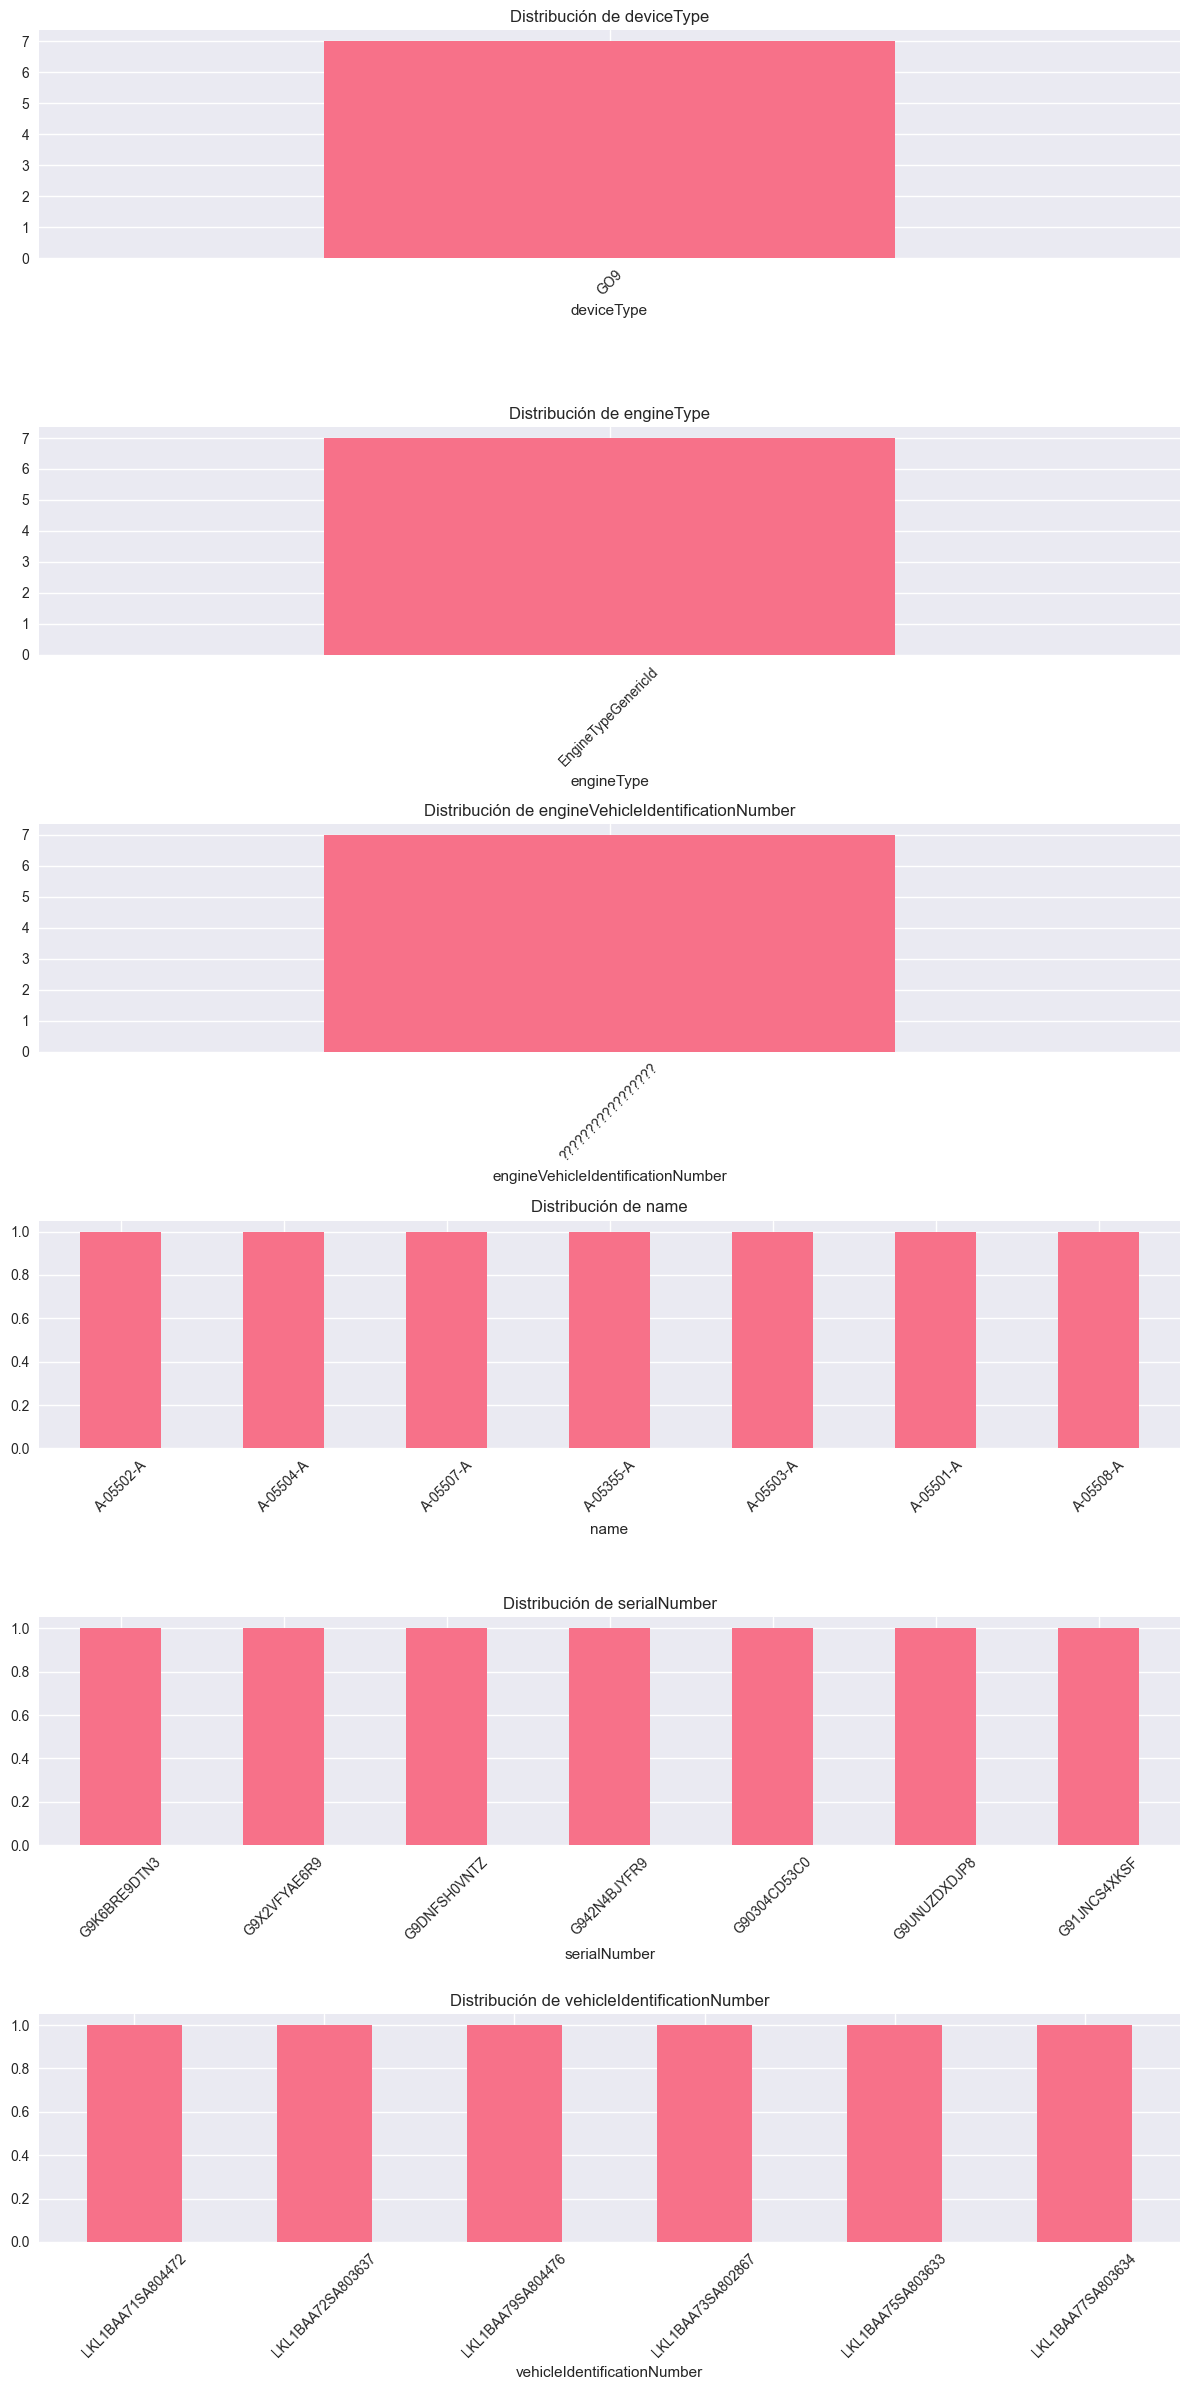

In [14]:
# Análisis de dispositivos/vehículos
if 'Device' in datasets:
    devices_df = datasets['Device']
    
    print("🚗 ANÁLISIS DE DISPOSITIVOS/VEHÍCULOS")
    print("="*50)
    
    # Información básica
    print(f"Total de dispositivos: {len(devices_df):,}")
    
    # Analizar campos específicos de dispositivos
    device_columns = devices_df.columns.tolist()
    print(f"\nColumnas disponibles ({len(device_columns)}):")
    for i, col in enumerate(device_columns, 1):
        print(f"{i:2}. {col}")
    
    # Buscar columnas relevantes para análisis
    relevant_cols = [col for col in device_columns if any(keyword in col.lower() 
                    for keyword in ['name', 'type', 'serial', 'vehicle', 'make', 'model', 'year'])]
    
    if relevant_cols:
        print(f"\n📋 Columnas relevantes identificadas:")
        for col in relevant_cols:
            if devices_df[col].dtype == 'object':
                unique_count = devices_df[col].nunique()
                print(f"  {col}: {unique_count:,} valores únicos")
                
                # Mostrar top valores para columnas categóricas
                if unique_count <= 20:
                    print(f"    Top valores: {devices_df[col].value_counts().head(3).to_dict()}")
    
    # Visualización básica si hay datos categóricos
    categorical_cols = [col for col in relevant_cols if devices_df[col].dtype == 'object' and devices_df[col].nunique() <= 15]
    
    if categorical_cols:
        fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(12, 4*len(categorical_cols)))
        if len(categorical_cols) == 1:
            axes = [axes]
        
        for i, col in enumerate(categorical_cols):
            value_counts = devices_df[col].value_counts().head(10)
            value_counts.plot(kind='bar', ax=axes[i], title=f'Distribución de {col}')
            axes[i].tick_params(axis='x', rotation=45)
            
        plt.tight_layout()
        plt.show()
else:
    print("❌ Dataset de dispositivos no disponible")

## 🛣️ Análisis de Viajes (Trips)

🛣️ ANÁLISIS DE VIAJES
Total de viajes: 6,696

Columnas disponibles (30):

🕐 Columnas de tiempo identificadas: ['afterHoursDrivingDuration', 'afterHoursStart', 'afterHoursStopDuration', 'drivingDuration', 'idlingDuration', 'nextTripStart', 'speedRange1Duration', 'speedRange2Duration', 'speedRange3Duration', 'start', 'stop', 'stopDuration', 'stopPoint', 'workDrivingDuration', 'workStopDuration']
📏 Columnas de distancia identificadas: ['afterHoursDistance', 'distance', 'workDistance']

🕐 ANÁLISIS DE TIMESTAMPS

Columna: afterHoursDrivingDuration
  Rango: 2025-11-06 00:00:00 a 2025-11-06 03:02:18.937000
  Valores válidos: 6,696/6,696
  Fechas más frecuentes:
afterHoursDrivingDuration
2025-11-06    6696
Name: count, dtype: int64

Columna: afterHoursStopDuration
  Rango: 2025-11-06 00:00:00 a 2025-11-06 19:21:58.232999
  Valores válidos: 6,686/6,696
  Fechas más frecuentes:
afterHoursStopDuration
2025-11-06    6686
Name: count, dtype: int64

Columna: drivingDuration
  Rango: 2025-11-06 00:00

C:\Users\steph\AppData\Local\Temp\ipykernel_3088\1139462025.py:106: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\steph\AppData\Local\Temp\ipykernel_3088\1139462025.py:106: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\steph\AppData\Local\Temp\ipykernel_3088\1139462025.py:106: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\steph\AppData\Local\Temp\ipykernel_3088\1139462025.py:106: UserWarning: Coul


Columna: stopDuration
  Rango: 2025-11-06 00:00:00 a 2025-11-06 23:27:30.067000
  Valores válidos: 6,682/6,696
  Fechas más frecuentes:
stopDuration
2025-11-06    6682
Name: count, dtype: int64


C:\Users\steph\AppData\Local\Temp\ipykernel_3088\1139462025.py:106: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\steph\AppData\Local\Temp\ipykernel_3088\1139462025.py:106: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')



Columna: workDrivingDuration
  Rango: 2025-11-06 00:00:00 a 2025-11-06 07:52:26
  Valores válidos: 6,696/6,696
  Fechas más frecuentes:
workDrivingDuration
2025-11-06    6696
Name: count, dtype: int64

Columna: workStopDuration
  Rango: 2025-11-06 00:00:00 a 2025-11-06 19:46:44
  Valores válidos: 6,691/6,696
  Fechas más frecuentes:
workStopDuration
2025-11-06    6691
Name: count, dtype: int64

📊 ESTADÍSTICAS DESCRIPTIVAS - COLUMNAS NUMÉRICAS
------------------------------------------------------------


C:\Users\steph\AppData\Local\Temp\ipykernel_3088\1139462025.py:106: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


,afterHoursDistance,averageSpeed,distance,engineHours,maximumSpeed,speedRange1,speedRange2,speedRange3,workDistance
count,6696.000000,6666.000000,6696.000000,6.696000e+03,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000
mean,4.003530,21.177702,16.035582,7.313683e+05,48.506123,0.251344,0.341398,0.122461,12.032051
std,14.904117,19.848074,25.572369,4.708186e+05,40.994041,1.055728,1.944931,0.811749,22.368228
min,0.000000,0.092593,0.000000,9.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.519038,0.055468,3.395925e+05,8.000000,0.000000,0.000000,0.000000,0.014661
50%,0.000000,13.402064,1.043092,6.770539e+05,39.000000,0.000000,0.000000,0.000000,0.315290
75%,0.000000,37.835535,28.963959,1.086751e+06,92.000000,0.000000,0.000000,0.000000,11.183286
max,151.708340,389.387760,334.260500,2.018602e+06,136.000000,13.000000,38.000000,17.000000,331.423400


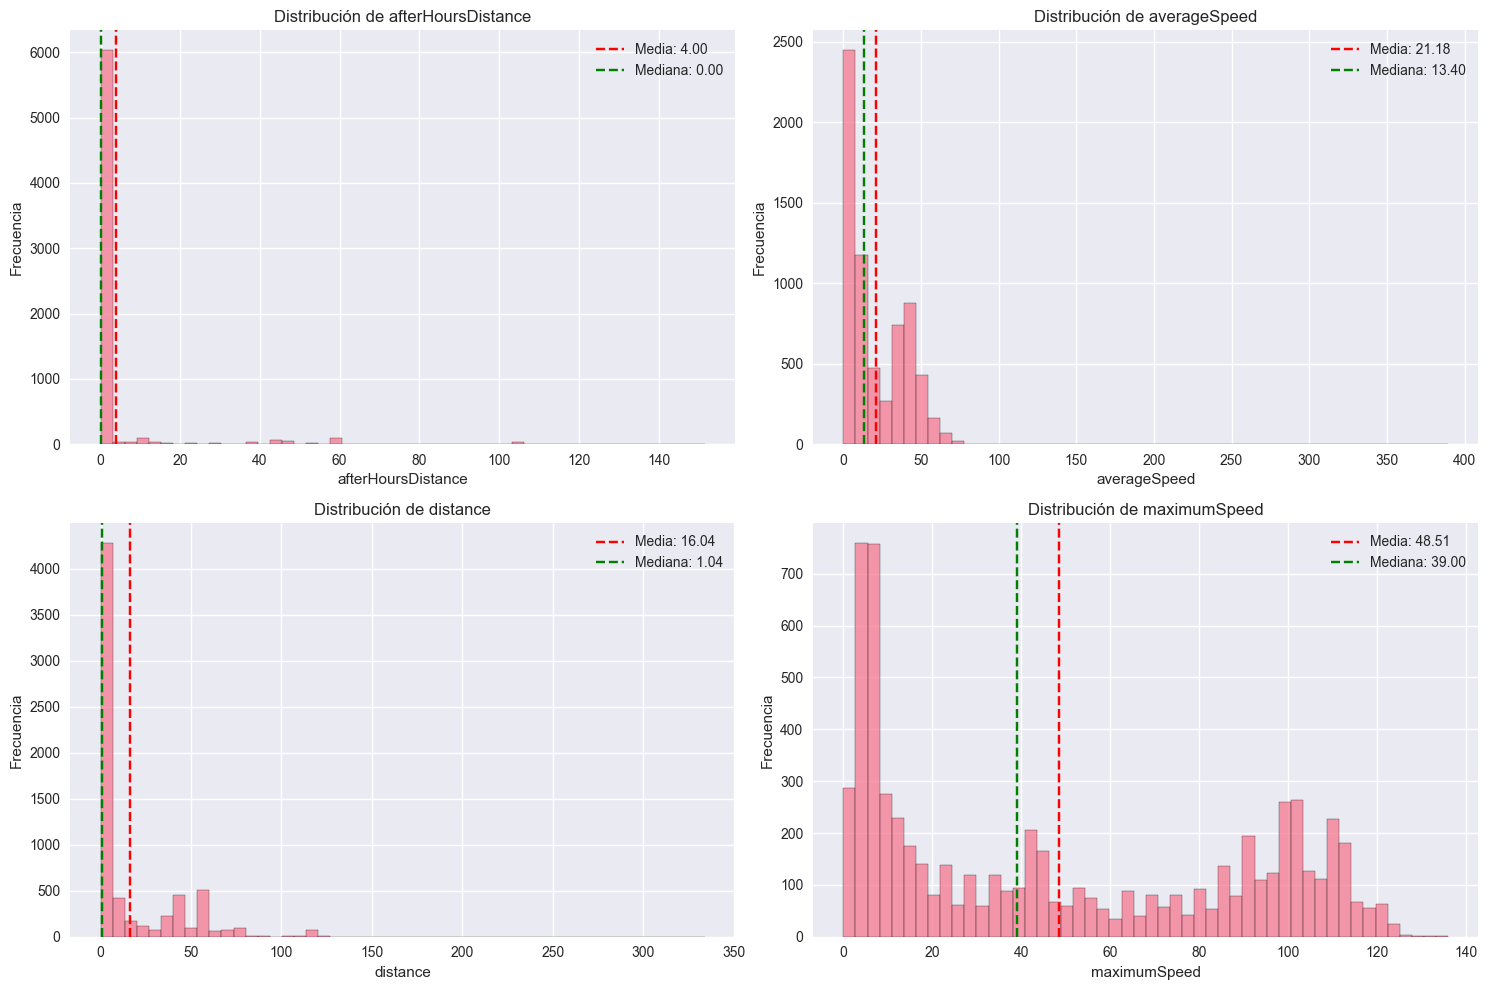


📅 PATRONES TEMPORALES - afterHoursDrivingDuration
----------------------------------------


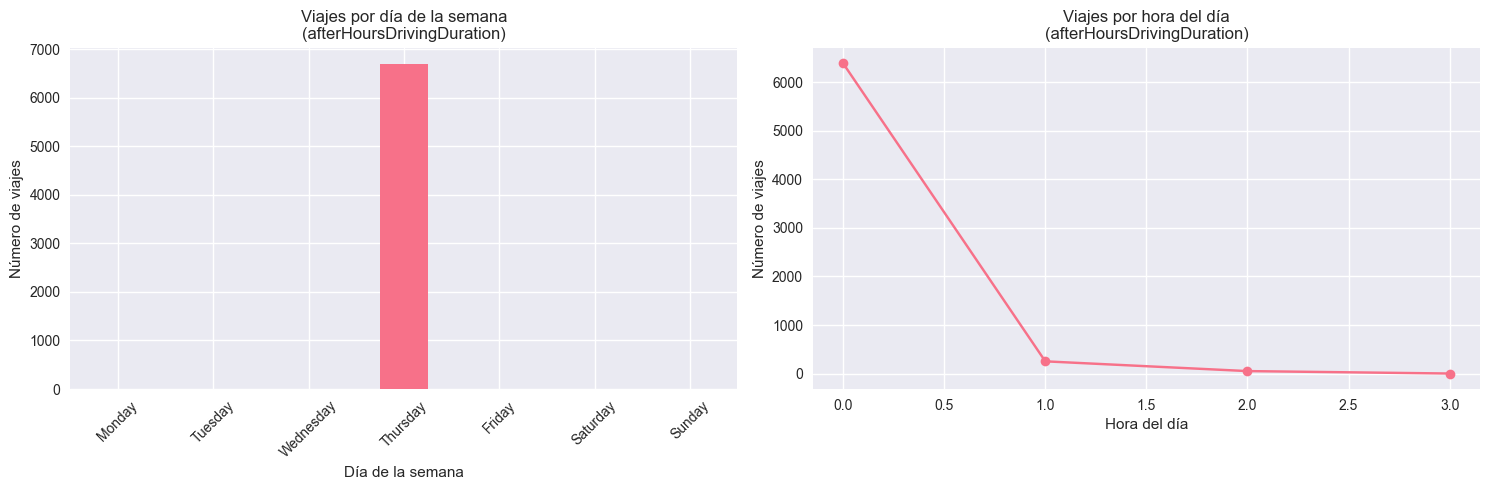

In [15]:
# Análisis de viajes
if 'Trip' in datasets:
    trips_df = datasets['Trip']
    
    print("🛣️ ANÁLISIS DE VIAJES")
    print("="*50)
    
    print(f"Total de viajes: {len(trips_df):,}")
    
    # Identificar columnas relacionadas con tiempo y distancia
    trip_columns = trips_df.columns.tolist()
    print(f"\nColumnas disponibles ({len(trip_columns)}):")
    
    # Buscar columnas de tiempo
    time_columns = [col for col in trip_columns if any(keyword in col.lower() 
                   for keyword in ['date', 'time', 'start', 'stop', 'duration'])]
    
    distance_columns = [col for col in trip_columns if any(keyword in col.lower() 
                       for keyword in ['distance', 'km', 'miles', 'odometer'])]
    
    print(f"\n🕐 Columnas de tiempo identificadas: {time_columns}")
    print(f"📏 Columnas de distancia identificadas: {distance_columns}")
    
    # Análisis temporal si hay columnas de tiempo
    if time_columns:
        analyze_geotab_timestamps(trips_df, time_columns)
    
    # Análisis de métricas numéricas
    numeric_columns = trips_df.select_dtypes(include=[np.number]).columns.tolist()
    
    if numeric_columns:
        print(f"\n📊 ESTADÍSTICAS DESCRIPTIVAS - COLUMNAS NUMÉRICAS")
        print("-" * 60)
        display(trips_df[numeric_columns].describe())
        
        # Visualización de distribuciones para métricas importantes
        important_metrics = [col for col in numeric_columns if any(keyword in col.lower() 
                           for keyword in ['distance', 'duration', 'speed', 'fuel', 'cost'])]
        
        if important_metrics:
            n_metrics = min(len(important_metrics), 4)
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            axes = axes.flatten()
            
            for i, metric in enumerate(important_metrics[:n_metrics]):
                data = trips_df[metric].dropna()
                if len(data) > 0:
                    axes[i].hist(data, bins=50, alpha=0.7, edgecolor='black')
                    axes[i].set_title(f'Distribución de {metric}')
                    axes[i].set_xlabel(metric)
                    axes[i].set_ylabel('Frecuencia')
                    
                    # Estadísticas básicas
                    mean_val = data.mean()
                    median_val = data.median()
                    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.2f}')
                    axes[i].axvline(median_val, color='green', linestyle='--', label=f'Mediana: {median_val:.2f}')
                    axes[i].legend()
            
            plt.tight_layout()
            plt.show()
        
    # Análisis de patrones temporales si hay columnas de fecha/hora
    if time_columns:
        for time_col in time_columns[:2]:  # Analizar máximo 2 columnas de tiempo
            if time_col in trips_df.columns:
                try:
                    trips_df[time_col] = pd.to_datetime(trips_df[time_col], errors='coerce')
                    valid_times = trips_df[time_col].dropna()
                    
                    if len(valid_times) > 100:
                        print(f"\n📅 PATRONES TEMPORALES - {time_col}")
                        print("-" * 40)
                        
                        # Distribución por día de la semana
                        if len(valid_times) > 50:
                            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
                            
                            # Por día de la semana
                            day_counts = valid_times.dt.day_name().value_counts()
                            day_counts.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind='bar', ax=ax1)
                            ax1.set_title(f'Viajes por día de la semana\n({time_col})')
                            ax1.set_xlabel('Día de la semana')
                            ax1.set_ylabel('Número de viajes')
                            ax1.tick_params(axis='x', rotation=45)
                            
                            # Por hora del día
                            hour_counts = valid_times.dt.hour.value_counts().sort_index()
                            hour_counts.plot(kind='line', ax=ax2, marker='o')
                            ax2.set_title(f'Viajes por hora del día\n({time_col})')
                            ax2.set_xlabel('Hora del día')
                            ax2.set_ylabel('Número de viajes')
                            ax2.grid(True)
                            
                            plt.tight_layout()
                            plt.show()
                            
                except Exception as e:
                    print(f"Error procesando {time_col}: {e}")
else:
    print("❌ Dataset de viajes no disponible")

## 👥 Análisis de Usuarios (Conductores)

👥 ANÁLISIS DE USUARIOS/CONDUCTORES
Total de usuarios: 3

Columnas relevantes identificadas: ['accessGroupFilter', 'activeDashboardReports', 'activeDefaultDashboards', 'activeFrom', 'activeTo', 'authorityName', 'companyGroups', 'companyName', 'employeeNo', 'firstName', 'isDriver', 'lastName', 'name', 'privateUserGroups', 'reportGroups', 'securityGroups']

accessGroupFilter: 3 valores únicos
Top valores:
accessGroupFilter
{'id': 'a3_fyPEd7Z0usyfRDGMknIg'}    1
{'id': 'aK6kNlWUnG0eg3SV9FsLCIw'}    1
{'id': 'aFMQxMiSAGkeb6MKctynIyg'}    1
Name: count, dtype: int64

activeDashboardReports: 2 valores únicos
Top valores:
activeDashboardReports
[]                 2
['b2B', 'b154']    1
Name: count, dtype: int64

activeDefaultDashboards: 1 valores únicos

activeFrom: 3 valores únicos
Top valores:
activeFrom
2025-09-01 22:51:48.418000+00:00    1
2025-09-01 22:53:13.211000+00:00    1
2025-09-01 22:52:33.096000+00:00    1
Name: count, dtype: int64

activeTo: 1 valores únicos

authorityName: 1 valo

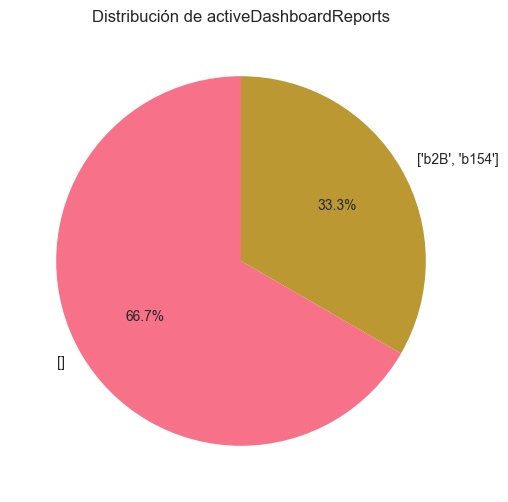


📊 Estado de activación - activeDefaultDashboards:
activeDefaultDashboards
[]    3
Name: count, dtype: int64


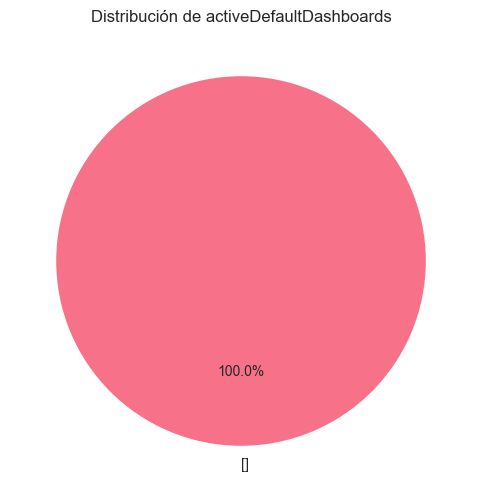


📊 Estado de activación - activeFrom:
activeFrom
2025-09-01 22:51:48.418000+00:00    1
2025-09-01 22:53:13.211000+00:00    1
2025-09-01 22:52:33.096000+00:00    1
Name: count, dtype: int64


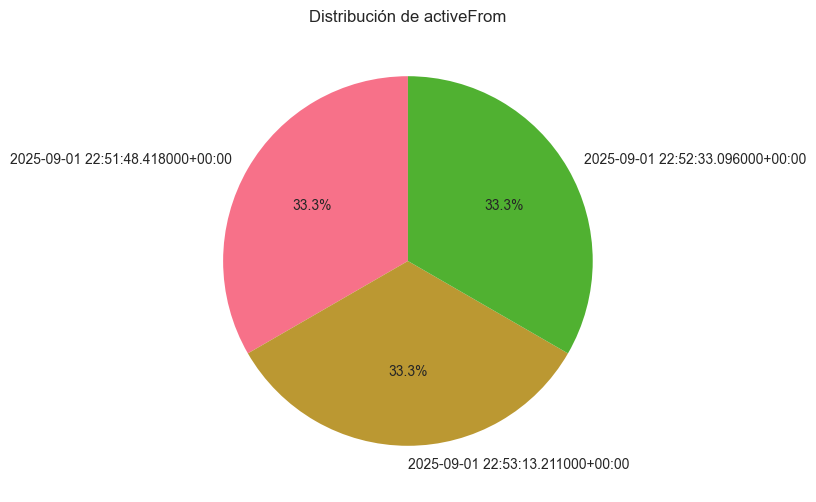


📊 Estado de activación - activeTo:
activeTo
2050-01-01 00:00:00+00:00    3
Name: count, dtype: int64


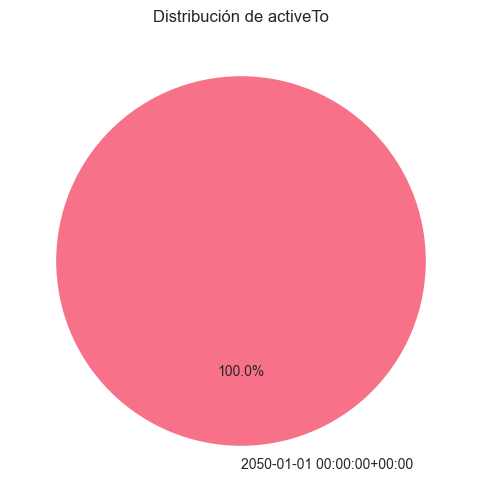

In [16]:
# Análisis de usuarios/conductores
if 'User' in datasets:
    users_df = datasets['User']
    
    print("👥 ANÁLISIS DE USUARIOS/CONDUCTORES")
    print("="*50)
    
    print(f"Total de usuarios: {len(users_df):,}")
    
    # Identificar campos relevantes
    user_columns = users_df.columns.tolist()
    relevant_user_cols = [col for col in user_columns if any(keyword in col.lower() 
                         for keyword in ['name', 'license', 'employee', 'driver', 'active', 'group'])]
    
    print(f"\nColumnas relevantes identificadas: {relevant_user_cols}")
    
    # Análisis de campos categóricos
    for col in relevant_user_cols:
        if col in users_df.columns and users_df[col].dtype == 'object':
            unique_values = users_df[col].nunique()
            print(f"\n{col}: {unique_values:,} valores únicos")
            
            if unique_values <= 20 and unique_values > 1:
                value_counts = users_df[col].value_counts().head(10)
                print(f"Top valores:\n{value_counts}")
    
    # Distribución de usuarios activos vs inactivos (si existe el campo)
    active_cols = [col for col in user_columns if 'active' in col.lower()]
    if active_cols:
        for active_col in active_cols:
            print(f"\n📊 Estado de activación - {active_col}:")
            status_counts = users_df[active_col].value_counts()
            print(status_counts)
            
            # Visualización
            plt.figure(figsize=(8, 6))
            status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
            plt.title(f'Distribución de {active_col}')
            plt.ylabel('')
            plt.show()
            
else:
    print("❌ Dataset de usuarios no disponible")

## 🗺️ Análisis de Zonas Geográficas

🗺️ ANÁLISIS DE ZONAS GEOGRÁFICAS
Total de zonas: 124

Columnas relevantes identificadas: ['geometryType', 'name', 'points', 'zoneTypes']

📋 Tipos de zonas - geometryType:
geometryType
Polygon    124
Name: count, dtype: int64


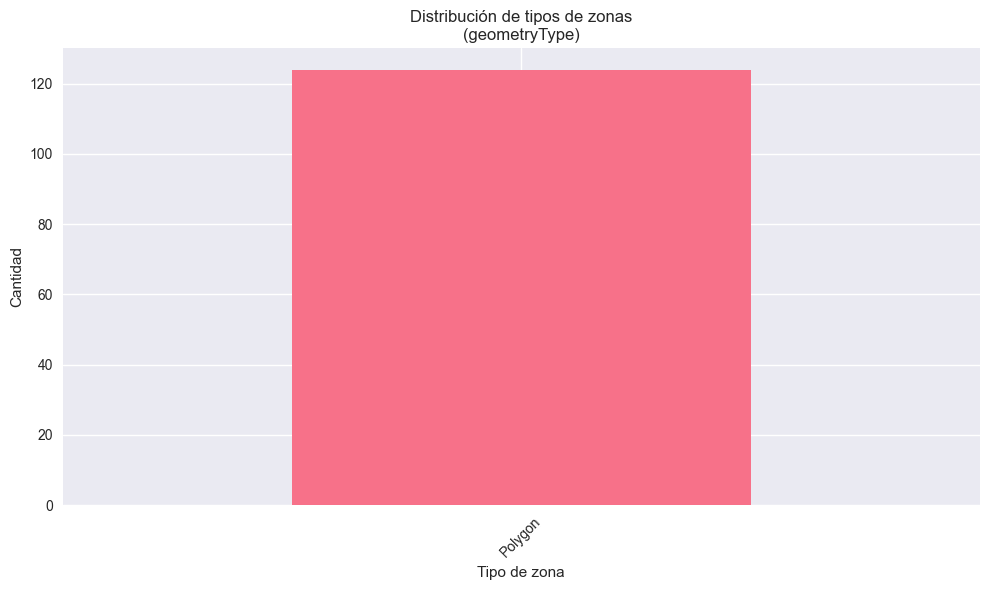


📋 Tipos de zonas - zoneTypes:
zoneTypes
['ZoneTypeCustomerId']               57
['ZoneTypeVendorServiceCenterId']    57
[{'id': 'b19'}]                       2
[{'id': 'b3D'}]                       2
[{'id': 'b17'}]                       1
[{'id': 'b1A'}]                       1
[{'id': 'b30'}]                       1
[]                                    1
[{'id': 'bB6'}]                       1
[{'id': 'b14'}]                       1
Name: count, dtype: int64


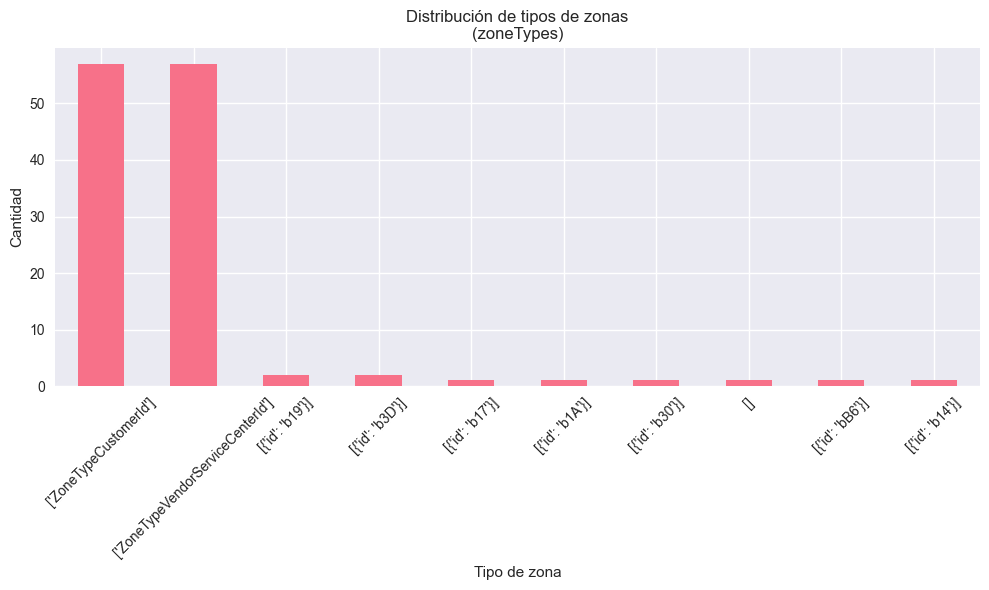


🌐 Columnas de coordenadas encontradas: ['points']


In [17]:
# Análisis de zonas geográficas
if 'Zone' in datasets:
    zones_df = datasets['Zone']
    
    print("🗺️ ANÁLISIS DE ZONAS GEOGRÁFICAS")
    print("="*50)
    
    print(f"Total de zonas: {len(zones_df):,}")
    
    # Identificar campos relevantes para zonas
    zone_columns = zones_df.columns.tolist()
    relevant_zone_cols = [col for col in zone_columns if any(keyword in col.lower() 
                         for keyword in ['name', 'type', 'size', 'points', 'coordinates', 'address'])]
    
    print(f"\nColumnas relevantes identificadas: {relevant_zone_cols}")
    
    # Análisis de tipos de zonas
    type_cols = [col for col in zone_columns if 'type' in col.lower()]
    if type_cols:
        for type_col in type_cols:
            print(f"\n📋 Tipos de zonas - {type_col}:")
            zone_types = zones_df[type_col].value_counts()
            print(zone_types)
            
            # Visualización de tipos de zonas
            if len(zone_types) <= 15:
                plt.figure(figsize=(10, 6))
                zone_types.plot(kind='bar')
                plt.title(f'Distribución de tipos de zonas\n({type_col})')
                plt.xlabel('Tipo de zona')
                plt.ylabel('Cantidad')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
    
    # Análisis de coordenadas si están disponibles
    coord_cols = [col for col in zone_columns if any(keyword in col.lower() 
                 for keyword in ['lat', 'lng', 'longitude', 'coordinate', 'point'])]
    
    if coord_cols:
        print(f"\n🌐 Columnas de coordenadas encontradas: {coord_cols}")
        
        # Intentar extraer coordenadas numéricas
        numeric_coords = []
        for col in coord_cols:
            if zones_df[col].dtype in ['float64', 'int64']:
                numeric_coords.append(col)
        
        if len(numeric_coords) >= 2:
            print(f"Coordenadas numéricas disponibles para mapeo: {numeric_coords[:2]}")
            
            # Estadísticas básicas de coordenadas
            coord_data = zones_df[numeric_coords[:2]].dropna()
            if len(coord_data) > 0:
                print(f"\nEstadísticas de coordenadas:")
                display(coord_data.describe())
                
                # Scatter plot de coordenadas
                plt.figure(figsize=(10, 8))
                plt.scatter(coord_data.iloc[:, 0], coord_data.iloc[:, 1], alpha=0.6)
                plt.xlabel(numeric_coords[0])
                plt.ylabel(numeric_coords[1])
                plt.title('Distribución geográfica de zonas')
                plt.grid(True, alpha=0.3)
                plt.show()

else:
    print("❌ Dataset de zonas no disponible")

## ⚠️ Análisis de Datos de Fallas

⚠️ ANÁLISIS DE DATOS DE FALLAS
Total de registros de fallas: 5,519

Columnas relevantes identificadas: ['diagnostic', 'diagnosticSeverity', 'faultState', 'faultStates', 'severity', 'sourceAddress']

🔍 Códigos de diagnóstico más frecuentes - diagnostic:
diagnostic
{'id': 'asmsNmIhBEkug4_fPPcxGjw'}                                 1895
{'id': 'DiagnosticGeneralVehicleWarningLightId'}                  1722
{'id': 'aRayqcO358UOecqMvt8JlHw'}                                 1551
{'id': 'acfsDwccGWkKoiDnaHQwOKg'}                                  187
{'id': 'aeAx1iIdw7U28BQED9dJ7Fg'}                                   53
{'id': 'awtSaua-9c06ewJ__HdXlBQ'}                                   31
{'id': 'DiagnosticDeviceRestartedBecauseOfFirmwareUpdateId'}        26
{'id': 'DiagnosticAccidentLevelAccelerationEventId'}                19
{'id': 'ac6izgCDNSUmB1dGxAW47gQ'}                                   14
{'id': 'DiagnosticDeviceRestartedBecauseAllPowerWasRemovedId'}      11
Name: count, dtype: int64


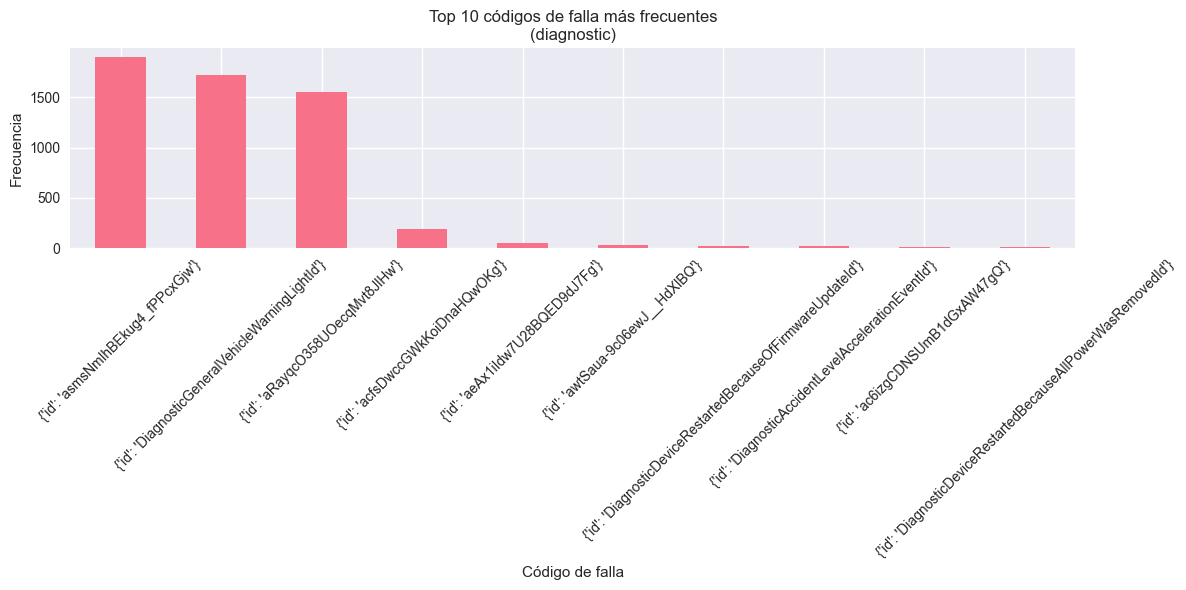


🔍 Códigos de diagnóstico más frecuentes - diagnosticSeverity:
diagnosticSeverity
MaintenanceOnly    3637
Name: count, dtype: int64

📅 PATRONES TEMPORALES DE FALLAS - dateTime
--------------------------------------------------


C:\Users\steph\AppData\Local\Temp\ipykernel_3088\2072994977.py:54: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_faults = valid_times.dt.to_period('M').value_counts().sort_index()


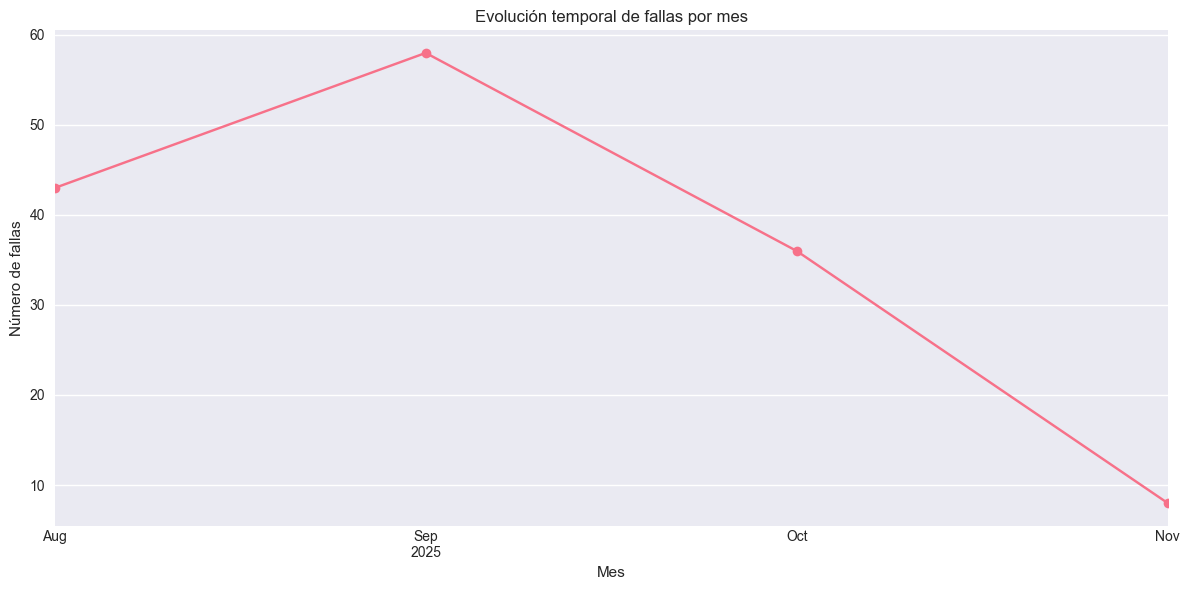

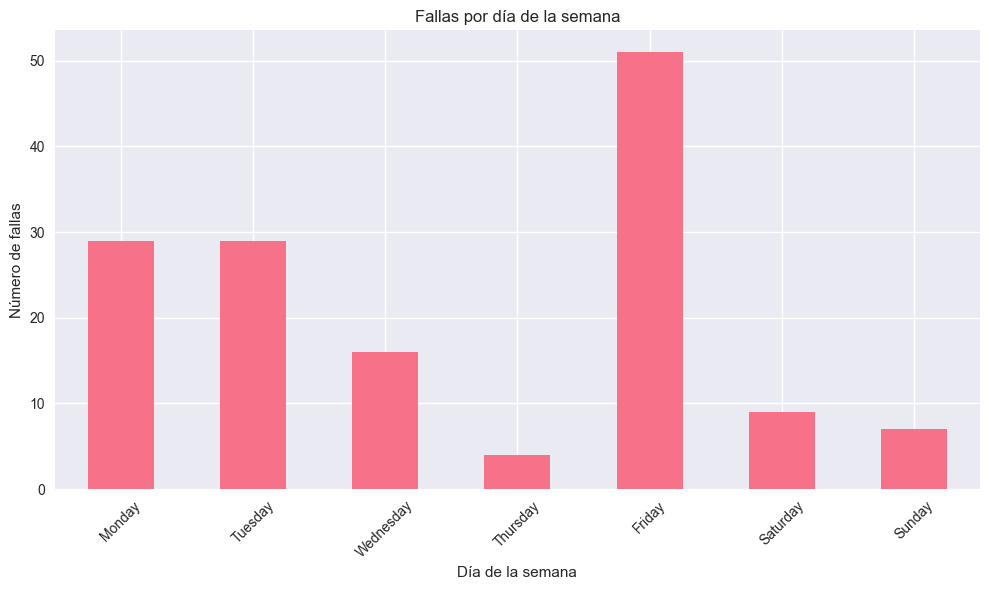


⚡ Distribución de severidad - diagnosticSeverity:
diagnosticSeverity
MaintenanceOnly    3637
Name: count, dtype: int64


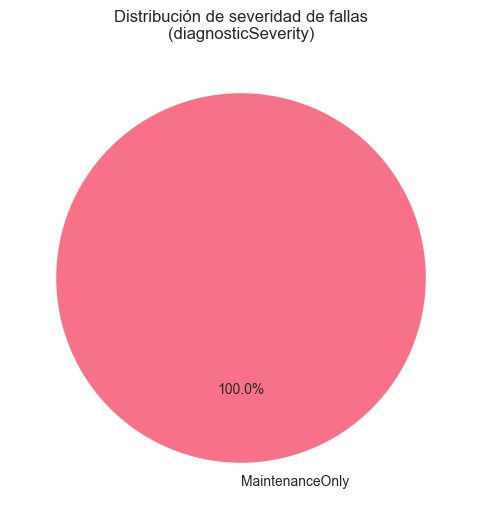


⚡ Distribución de severidad - severity:
severity
MaintenanceOnly    3637
Name: count, dtype: int64


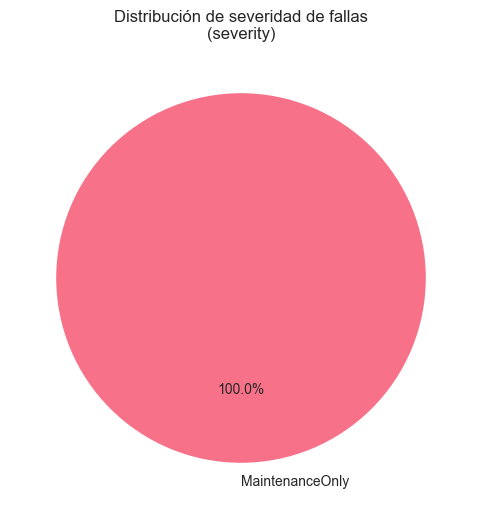

In [18]:
# Análisis de datos de fallas
if 'FaultData' in datasets:
    faults_df = datasets['FaultData']
    
    print("⚠️ ANÁLISIS DE DATOS DE FALLAS")
    print("="*50)
    
    print(f"Total de registros de fallas: {len(faults_df):,}")
    
    # Identificar campos relevantes para fallas
    fault_columns = faults_df.columns.tolist()
    relevant_fault_cols = [col for col in fault_columns if any(keyword in col.lower() 
                          for keyword in ['diagnostic', 'code', 'severity', 'description', 'source', 'state'])]
    
    print(f"\nColumnas relevantes identificadas: {relevant_fault_cols}")
    
    # Análisis de códigos de diagnóstico
    diagnostic_cols = [col for col in fault_columns if any(keyword in col.lower() 
                      for keyword in ['diagnostic', 'code', 'dtc'])]
    
    if diagnostic_cols:
        for diag_col in diagnostic_cols:
            if faults_df[diag_col].dtype == 'object':
                print(f"\n🔍 Códigos de diagnóstico más frecuentes - {diag_col}:")
                top_codes = faults_df[diag_col].value_counts().head(10)
                print(top_codes)
                
                # Visualización de top códigos de falla
                if len(top_codes) > 1:
                    plt.figure(figsize=(12, 6))
                    top_codes.plot(kind='bar')
                    plt.title(f'Top 10 códigos de falla más frecuentes\n({diag_col})')
                    plt.xlabel('Código de falla')
                    plt.ylabel('Frecuencia')
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()
    
    # Análisis temporal de fallas
    time_cols = [col for col in fault_columns if any(keyword in col.lower() 
                for keyword in ['date', 'time', 'timestamp'])]
    
    if time_cols:
        for time_col in time_cols[:1]:  # Analizar solo la primera columna de tiempo
            try:
                faults_df[time_col] = pd.to_datetime(faults_df[time_col], errors='coerce')
                valid_times = faults_df[time_col].dropna()
                
                if len(valid_times) > 50:
                    print(f"\n📅 PATRONES TEMPORALES DE FALLAS - {time_col}")
                    print("-" * 50)
                    
                    # Fallas por mes
                    monthly_faults = valid_times.dt.to_period('M').value_counts().sort_index()
                    
                    if len(monthly_faults) > 1:
                        plt.figure(figsize=(12, 6))
                        monthly_faults.plot(kind='line', marker='o')
                        plt.title('Evolución temporal de fallas por mes')
                        plt.xlabel('Mes')
                        plt.ylabel('Número de fallas')
                        plt.grid(True)
                        plt.xticks(rotation=45)
                        plt.tight_layout()
                        plt.show()
                    
                    # Fallas por día de la semana
                    daily_faults = valid_times.dt.day_name().value_counts()
                    daily_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                    daily_faults_ordered = daily_faults.reindex(daily_order, fill_value=0)
                    
                    plt.figure(figsize=(10, 6))
                    daily_faults_ordered.plot(kind='bar')
                    plt.title('Fallas por día de la semana')
                    plt.xlabel('Día de la semana')
                    plt.ylabel('Número de fallas')
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()
                    
            except Exception as e:
                print(f"Error procesando {time_col}: {e}")
    
    # Análisis de severidad si está disponible
    severity_cols = [col for col in fault_columns if 'severity' in col.lower() or 'priority' in col.lower()]
    
    if severity_cols:
        for sev_col in severity_cols:
            print(f"\n⚡ Distribución de severidad - {sev_col}:")
            severity_dist = faults_df[sev_col].value_counts()
            print(severity_dist)
            
            # Gráfico de severidad
            plt.figure(figsize=(8, 6))
            severity_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90)
            plt.title(f'Distribución de severidad de fallas\n({sev_col})')
            plt.ylabel('')
            plt.show()

else:
    print("❌ Dataset de datos de fallas no disponible")

## 📏 Análisis de Reglas de Negocio

📏 ANÁLISIS DE REGLAS DE NEGOCIO
Total de reglas: 70

Columnas relevantes identificadas: ['activeFrom', 'activeTo', 'baseType', 'condition', 'groups', 'name']

📋 Tipos de reglas - baseType:
baseType
Custom    51
Stock     19
Name: count, dtype: int64


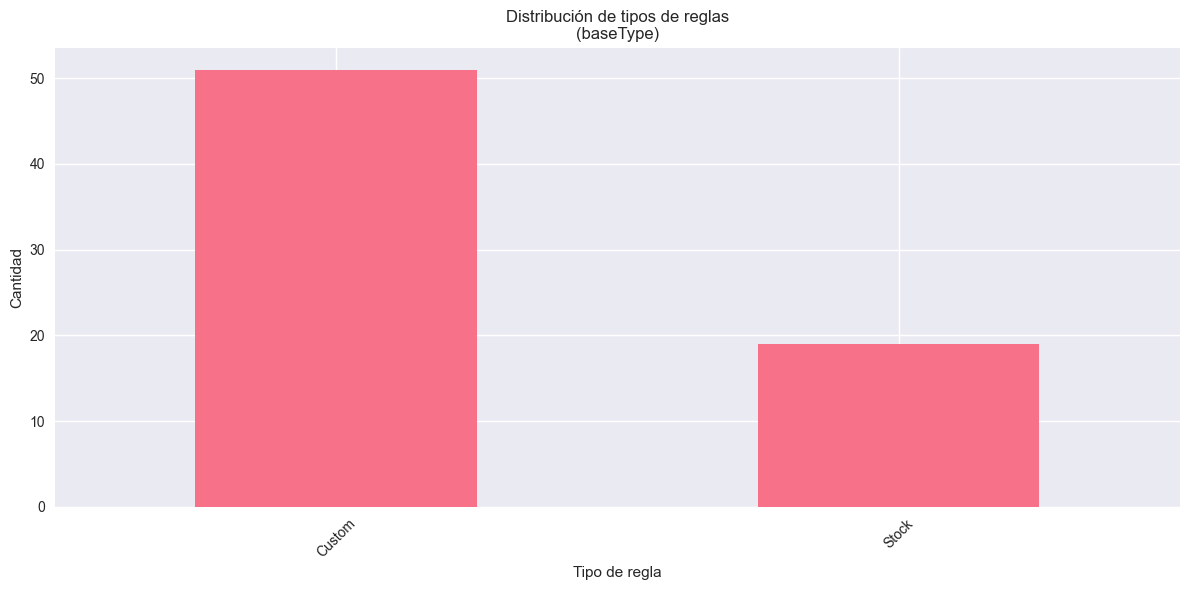


✅ Estado de activación - activeFrom:
activeFrom
2024-04-02 17:14:21+00:00           11
2025-10-08 14:15:28+00:00            3
2025-09-18 18:06:36.193000+00:00     1
2025-07-18 16:10:43.002000+00:00     1
2023-03-16 22:20:34.078000+00:00     1
2025-03-14 16:40:52.226000+00:00     1
2025-05-22 19:33:00.505000+00:00     1
2025-03-27 05:23:58.347000+00:00     1
2024-07-16 01:22:08+00:00            1
2025-09-10 17:05:07.694000+00:00     1
2021-06-16 15:16:01.570000+00:00     1
2021-10-06 17:47:11.917000+00:00     1
2021-10-06 17:46:40.133000+00:00     1
2023-07-24 23:33:59.256000+00:00     1
2024-06-13 18:26:50.962000+00:00     1
2023-12-19 15:37:25.945000+00:00     1
2025-07-18 16:10:39.614000+00:00     1
2025-01-23 04:24:50.392000+00:00     1
2021-10-06 17:46:56.253000+00:00     1
2025-04-12 00:27:29.010000+00:00     1
2025-11-06 17:17:11.786000+00:00     1
2025-07-18 16:10:40.398000+00:00     1
2021-06-16 15:15:52.477000+00:00     1
2024-11-14 16:30:43.963000+00:00     1
2024-12-11 19:0

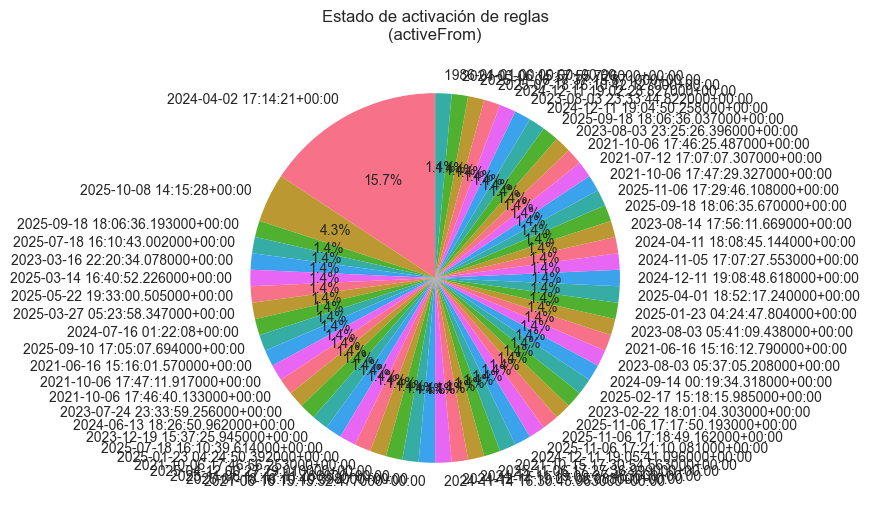


✅ Estado de activación - activeTo:
activeTo
2050-01-01 00:00:00+00:00    70
Name: count, dtype: int64


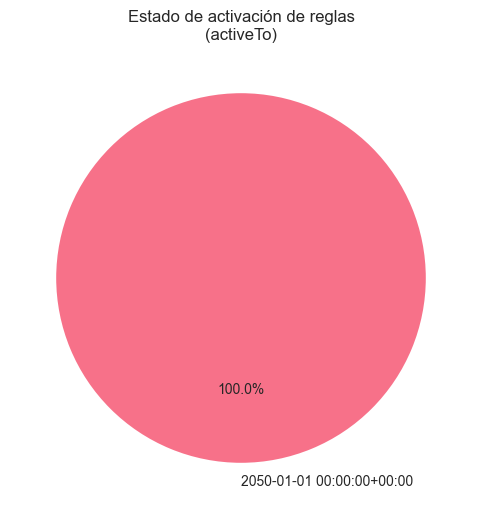


📝 Nombres de reglas únicos (name): 70


In [19]:
# Análisis de reglas de negocio
if 'Rule' in datasets:
    rules_df = datasets['Rule']
    
    print("📏 ANÁLISIS DE REGLAS DE NEGOCIO")
    print("="*50)
    
    print(f"Total de reglas: {len(rules_df):,}")
    
    # Identificar campos relevantes para reglas
    rule_columns = rules_df.columns.tolist()
    relevant_rule_cols = [col for col in rule_columns if any(keyword in col.lower() 
                         for keyword in ['name', 'type', 'active', 'condition', 'action', 'group'])]
    
    print(f"\nColumnas relevantes identificadas: {relevant_rule_cols}")
    
    # Análisis de tipos de reglas
    type_cols = [col for col in rule_columns if 'type' in col.lower()]
    if type_cols:
        for type_col in type_cols:
            print(f"\n📋 Tipos de reglas - {type_col}:")
            rule_types = rules_df[type_col].value_counts()
            print(rule_types)
            
            # Visualización de tipos de reglas
            if len(rule_types) <= 15 and len(rule_types) > 1:
                plt.figure(figsize=(12, 6))
                rule_types.plot(kind='bar')
                plt.title(f'Distribución de tipos de reglas\n({type_col})')
                plt.xlabel('Tipo de regla')
                plt.ylabel('Cantidad')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
    
    # Análisis de reglas activas vs inactivas
    active_cols = [col for col in rule_columns if 'active' in col.lower()]
    if active_cols:
        for active_col in active_cols:
            print(f"\n✅ Estado de activación - {active_col}:")
            active_status = rules_df[active_col].value_counts()
            print(active_status)
            
            # Gráfico de estado de reglas
            plt.figure(figsize=(8, 6))
            active_status.plot(kind='pie', autopct='%1.1f%%', startangle=90)
            plt.title(f'Estado de activación de reglas\n({active_col})')
            plt.ylabel('')
            plt.show()
    
    # Análisis de nombres de reglas para identificar patrones
    name_cols = [col for col in rule_columns if 'name' in col.lower()]
    if name_cols:
        for name_col in name_cols:
            if rules_df[name_col].dtype == 'object':
                unique_names = rules_df[name_col].nunique()
                print(f"\n📝 Nombres de reglas únicos ({name_col}): {unique_names:,}")
                
                # Buscar palabras clave comunes en nombres de reglas
                if unique_names > 5 and unique_names < len(rules_df):
                    rule_names = rules_df[name_col].dropna().astype(str)
                    
                    # Análisis de palabras clave en nombres
                    keywords = ['speed', 'idle', 'zone', 'fuel', 'harsh', 'brake', 'acceleration', 'overtime', 'maintenance']
                    keyword_counts = {}
                    
                    for keyword in keywords:
                        count = rule_names.str.lower().str.contains(keyword, na=False).sum()
                        if count > 0:
                            keyword_counts[keyword] = count
                    
                    if keyword_counts:
                        print(f"\nPalabras clave en nombres de reglas:")
                        for keyword, count in sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True):
                            print(f"  {keyword}: {count} reglas")
                        
                        # Visualización de palabras clave
                        if len(keyword_counts) > 1:
                            plt.figure(figsize=(10, 6))
                            keywords_df = pd.Series(keyword_counts)
                            keywords_df.plot(kind='bar')
                            plt.title('Palabras clave más frecuentes en nombres de reglas')
                            plt.xlabel('Palabra clave')
                            plt.ylabel('Número de reglas')
                            plt.xticks(rotation=45)
                            plt.tight_layout()
                            plt.show()

else:
    print("❌ Dataset de reglas no disponible")

## 🔗 Análisis Relacional entre Datasets

En esta sección exploraremos las relaciones entre los diferentes datasets para identificar patrones y correlaciones.

🔗 ANÁLISIS RELACIONAL ENTRE DATASETS
Device      : ['deviceFlags', 'devicePlanBillingInfo', 'devicePlans', 'deviceType', 'enableBeepOnIdle', 'engineVehicleIdentificationNumber', 'externalDeviceShutDownDelay', 'id', 'idleMinutes', 'minAccidentSpeed', 'parameterVersionOnDevice', 'pinDevice', 'productId', 'timeZoneId', 'vehicleIdentificationNumber']
FaultData   : ['device', 'id']
Rule        : ['id']
Trip        : ['device', 'id', 'idlingDuration', 'nextTripStart']
User        : ['driveGuideVersion', 'id', 'privateUserGroups', 'timeZoneId', 'userAuthenticationType']
Zone        : ['id', 'mustIdentifyStops']

🔍 BUSCANDO RELACIONES ENTRE DATASETS:
--------------------------------------------------
Campos de dispositivo en trips: ['device']
Campos de ID en devices: ['enableBeepOnIdle', 'engineVehicleIdentificationNumber', 'id', 'idleMinutes', 'minAccidentSpeed', 'productId', 'timeZoneId', 'vehicleIdentificationNumber']

Dispositivos en trips: 7
Total de dispositivos: 7
Cobertura: 100.0%

Top

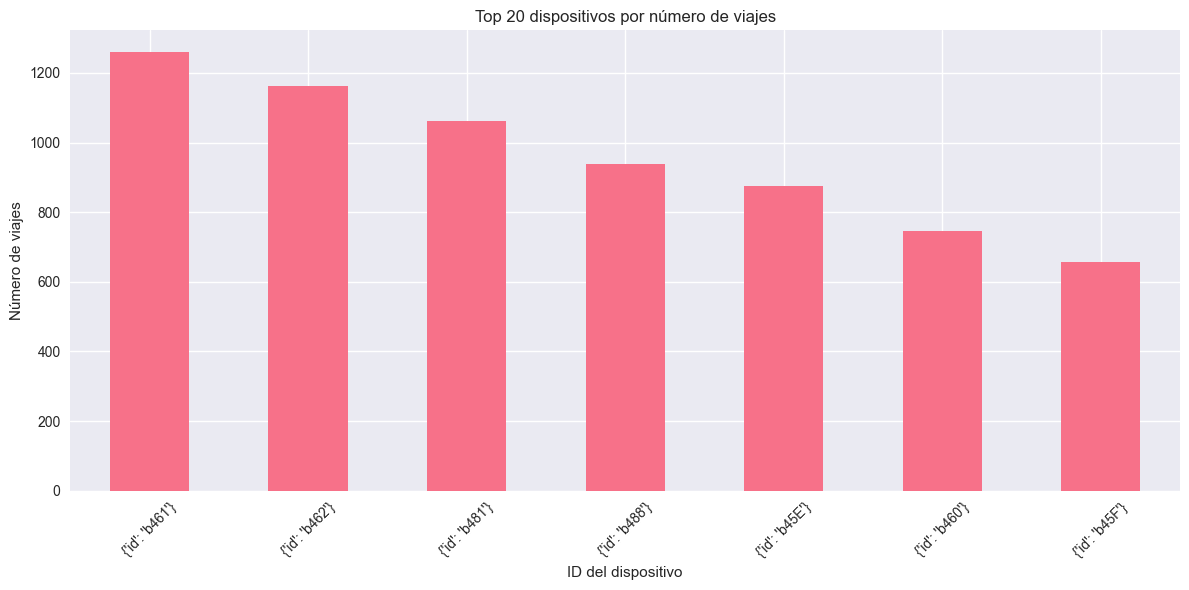


👥 Análisis de usuarios en viajes:
Usuarios que han realizado viajes: 1
Total de usuarios: 3

Estadísticas de viajes por usuario:
  Media: 6696.0 viajes/usuario
  Mediana: 6696.0 viajes/usuario
  Máximo: 6,696 viajes


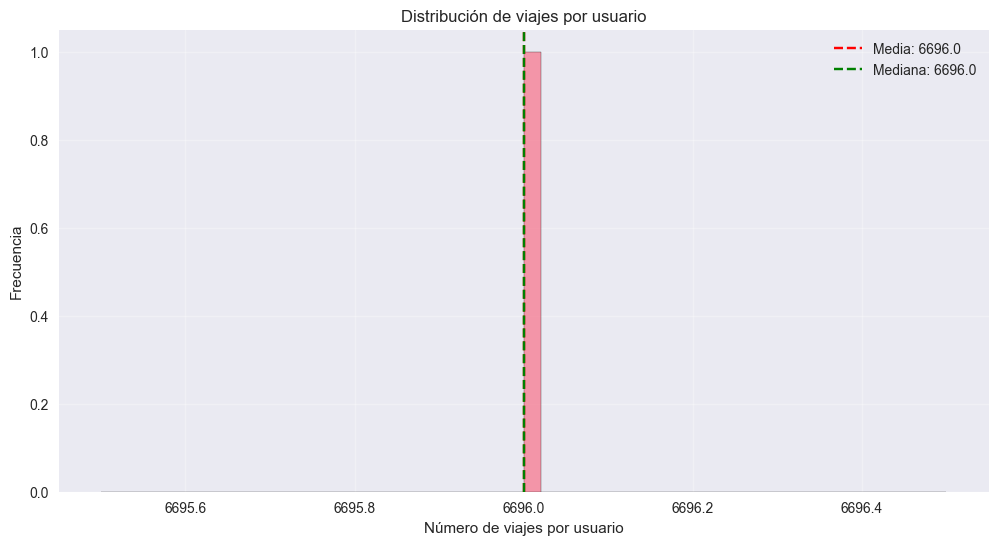


✅ Análisis relacional completado


In [20]:
# Análisis relacional entre datasets
print("🔗 ANÁLISIS RELACIONAL ENTRE DATASETS")
print("="*60)

# Buscar campos de ID comunes que podrían servir como claves de relación
potential_id_fields = {}

for name, df in datasets.items():
    id_columns = [col for col in df.columns if any(keyword in col.lower() 
                 for keyword in ['id', 'key', 'device', 'user', 'trip'])]
    potential_id_fields[name] = id_columns
    print(f"{name:12}: {id_columns}")

# Buscar overlaps en IDs entre datasets
print(f"\n🔍 BUSCANDO RELACIONES ENTRE DATASETS:")
print("-" * 50)

# Comparar entre trips y devices
if 'Trip' in datasets and 'Device' in datasets:
    trips_df = datasets['Trip']
    devices_df = datasets['Device']
    
    # Buscar campos que podrían relacionar trips con devices
    device_id_fields_in_trips = [col for col in trips_df.columns if 'device' in col.lower()]
    device_id_fields_in_devices = [col for col in devices_df.columns if 'id' in col.lower()]
    
    print(f"Campos de dispositivo en trips: {device_id_fields_in_trips}")
    print(f"Campos de ID en devices: {device_id_fields_in_devices}")
    
    # Si encontramos campos relacionados, analizar la relación
    if device_id_fields_in_trips and device_id_fields_in_devices:
        device_field_trips = device_id_fields_in_trips[0]
        device_field_devices = device_id_fields_in_devices[0]
        
        trips_devices = trips_df[device_field_trips].value_counts()
        total_devices_in_trips = trips_df[device_field_trips].nunique()
        total_devices = len(devices_df)
        
        print(f"\nDispositivos en trips: {total_devices_in_trips:,}")
        print(f"Total de dispositivos: {total_devices:,}")
        print(f"Cobertura: {total_devices_in_trips/total_devices*100:.1f}%")
        
        # Top dispositivos por número de viajes
        print(f"\nTop 10 dispositivos por número de viajes:")
        print(trips_devices.head(10))
        
        # Visualización
        plt.figure(figsize=(12, 6))
        trips_per_device = trips_devices.head(20)
        trips_per_device.plot(kind='bar')
        plt.title('Top 20 dispositivos por número de viajes')
        plt.xlabel('ID del dispositivo')
        plt.ylabel('Número de viajes')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Análisis de usuarios en trips
if 'Trip' in datasets and 'User' in datasets:
    trips_df = datasets['Trip']
    users_df = datasets['User']
    
    user_fields_in_trips = [col for col in trips_df.columns if any(keyword in col.lower() 
                           for keyword in ['user', 'driver', 'operator'])]
    
    if user_fields_in_trips:
        user_field = user_fields_in_trips[0]
        trips_by_user = trips_df[user_field].value_counts()
        total_users_in_trips = trips_df[user_field].nunique()
        
        print(f"\n👥 Análisis de usuarios en viajes:")
        print(f"Usuarios que han realizado viajes: {total_users_in_trips:,}")
        print(f"Total de usuarios: {len(users_df):,}")
        
        # Distribución de viajes por usuario
        print(f"\nEstadísticas de viajes por usuario:")
        print(f"  Media: {trips_by_user.mean():.1f} viajes/usuario")
        print(f"  Mediana: {trips_by_user.median():.1f} viajes/usuario")
        print(f"  Máximo: {trips_by_user.max():,} viajes")
        
        # Visualización de distribución
        plt.figure(figsize=(12, 6))
        plt.hist(trips_by_user, bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Número de viajes por usuario')
        plt.ylabel('Frecuencia')
        plt.title('Distribución de viajes por usuario')
        plt.axvline(trips_by_user.mean(), color='red', linestyle='--', 
                   label=f'Media: {trips_by_user.mean():.1f}')
        plt.axvline(trips_by_user.median(), color='green', linestyle='--', 
                   label=f'Mediana: {trips_by_user.median():.1f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

print("\n✅ Análisis relacional completado")

## 📈 Resumen Ejecutivo y Conclusiones

### 📋 Resumen de Datos Analizados

En esta sección resumimos los hallazgos principales del análisis exploratorio de los datos de Geotab.

📈 RESUMEN EJECUTIVO DEL ANÁLISIS

📊 RESUMEN GENERAL DE DATASETS:
---------------------------------------------


,Registros,Columnas,Memoria (MB),Valores Nulos (%),Duplicados
Dataset,,,,,
Device,7.0,74.0,0.03,0.97,0.0
FaultData,5519.0,19.0,4.39,19.86,0.0
Rule,70.0,13.0,0.18,6.04,0.0
Trip,6696.0,30.0,2.83,10.42,0.0
User,3.0,67.0,0.01,11.94,0.0
Zone,124.0,13.0,0.12,15.14,0.0


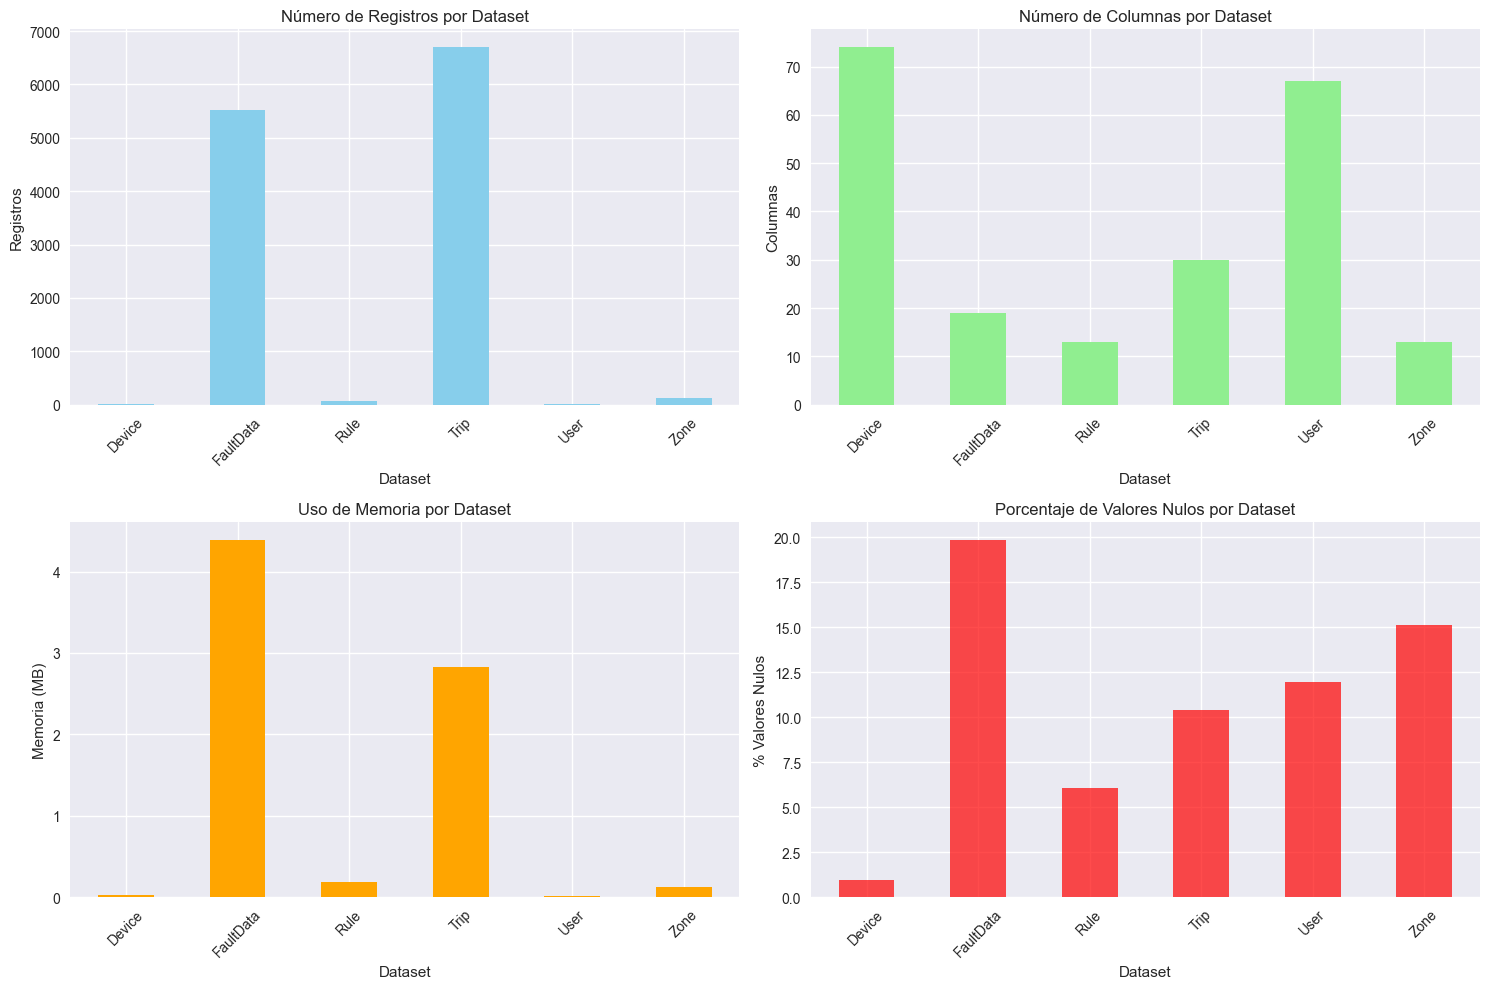


💡 RECOMENDACIONES PRINCIPALES:
----------------------------------------
 1. • Revisar calidad de datos: 10.7% de valores nulos promedio
 2. • Dataset más grande: Trip con 6,696.0 registros
 3. • Análisis de eficiencia de flota: correlacionar viajes con dispositivos
 4. • Mantenimiento predictivo: analizar 5,519 registros de fallas
 5. • Score de conducción: evaluar comportamiento de conductores

✅ Análisis exploratorio completado exitosamente
📁 Total de datasets analizados: 6
📊 Total de registros procesados: 12,419.0
💾 Memoria total utilizada: 7.6 MB


In [27]:
# Resumen ejecutivo del análisis
print("📈 RESUMEN EJECUTIVO DEL ANÁLISIS")
print("="*60)

# Crear un dashboard de resumen
summary_data = {}

for name, df in datasets.items():
    summary_data[name] = {
        'Registros': len(df),
        'Columnas': len(df.columns),
        'Memoria (MB)': round(df.memory_usage(deep=True).sum() / 1024**2, 2),
        'Valores Nulos (%)': round((df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100, 2),
        'Duplicados': df.duplicated().sum()
    }

# Convertir a DataFrame para mejor visualización
summary_df = pd.DataFrame(summary_data).T
summary_df.index.name = 'Dataset'

print("\n📊 RESUMEN GENERAL DE DATASETS:")
print("-" * 45)
display(summary_df)

# Gráfico de resumen
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Número de registros
summary_df['Registros'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Número de Registros por Dataset')
axes[0,0].set_ylabel('Registros')
axes[0,0].tick_params(axis='x', rotation=45)

# Número de columnas
summary_df['Columnas'].plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Número de Columnas por Dataset')
axes[0,1].set_ylabel('Columnas')
axes[0,1].tick_params(axis='x', rotation=45)

# Uso de memoria
summary_df['Memoria (MB)'].plot(kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Uso de Memoria por Dataset')
axes[1,0].set_ylabel('Memoria (MB)')
axes[1,0].tick_params(axis='x', rotation=45)

# Porcentaje de valores nulos
summary_df['Valores Nulos (%)'].plot(kind='bar', ax=axes[1,1], color='red', alpha=0.7)
axes[1,1].set_title('Porcentaje de Valores Nulos por Dataset')
axes[1,1].set_ylabel('% Valores Nulos')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Recomendaciones
print(f"\n💡 RECOMENDACIONES PRINCIPALES:")
print("-" * 40)

recommendations = []

# Análisis de calidad de datos
total_null_percentage = summary_df['Valores Nulos (%)'].mean()
if total_null_percentage > 10:
    recommendations.append(f"• Revisar calidad de datos: {total_null_percentage:.1f}% de valores nulos promedio")

# Análisis de duplicados
total_duplicates = summary_df['Duplicados'].sum()
if total_duplicates > 0:
    recommendations.append(f"• Implementar proceso de deduplicación: {total_duplicates:,} duplicados encontrados")

# Análisis de volumen de datos
largest_dataset = summary_df['Registros'].idxmax()
largest_size = summary_df.loc[largest_dataset, 'Registros']
recommendations.append(f"• Dataset más grande: {largest_dataset} con {largest_size:,} registros")

# Análisis de memoria
high_memory_datasets = summary_df[summary_df['Memoria (MB)'] > 10]
if len(high_memory_datasets) > 0:
    recommendations.append(f"• Optimizar memoria para: {list(high_memory_datasets.index)}")

# Recomendaciones específicas de Geotab
if 'Trip' in datasets and 'Device' in datasets:
    recommendations.append("• Análisis de eficiencia de flota: correlacionar viajes con dispositivos")

if 'FaultData' in datasets:
    fault_count = len(datasets['FaultData'])
    recommendations.append(f"• Mantenimiento predictivo: analizar {fault_count:,} registros de fallas")

if 'User' in datasets and 'Trip' in datasets:
    recommendations.append("• Score de conducción: evaluar comportamiento de conductores")

for i, rec in enumerate(recommendations, 1):
    print(f"{i:2}. {rec}")

print(f"\n✅ Análisis exploratorio completado exitosamente")
print(f"📁 Total de datasets analizados: {len(datasets)}")
print(f"📊 Total de registros procesados: {summary_df['Registros'].sum():,}")
print(f"💾 Memoria total utilizada: {summary_df['Memoria (MB)'].sum():.1f} MB")